In [21]:
import warnings
warnings.simplefilter('always')

import warnings
warnings.filterwarnings("ignore")

In [23]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation

import GPy
from GPy.models.gp_regression import GPRegression
from emukit.multi_fidelity.kernels.linear_multi_fidelity_kernel import LinearMultiFidelityKernel
from emukit.multi_fidelity.convert_lists_to_array import convert_xy_lists_to_arrays
from emukit.model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models.linear_model import GPyLinearMultiFidelityModel
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array
from emukit.core.loop.user_function import MultiSourceFunctionWrapper
from emukit.core.acquisition import Acquisition
from emukit.core.interfaces import IModel
from emukit.core import ParameterSpace, ContinuousParameter, InformationSourceParameter
from emukit.core.loop import FixedIntervalUpdater, OuterLoop, SequentialPointCalculator
from emukit.core.loop.loop_state import create_loop_state
from emukit.core.optimization.multi_source_acquisition_optimizer import MultiSourceAcquisitionOptimizer
from emukit.core.optimization import GradientAcquisitionOptimizer

In [25]:
plt.rcParams.update({
    "font.family": "serif",
    "font.sans-serif": "Computer Modern",
})
FIG_SIZE = (12, 8)

In [261]:
class multifidelityGPR:
    def __init__(self, lf, hf):
        self.LF = lf
        self.HF = hf
        self.multifidelity = MultiSourceFunctionWrapper([lf, hf])
        self.iterates = []
        self.GP_iterates = []

    def set_initial_data(self, n1, n2, bounds):
        lb, ub = bounds
        self.bounds = bounds
        np.random.seed(12346)
        x_low = np.random.rand(n1)[:, None]*(ub-lb) + lb
        x_high = x_low[:n2, :]
        y_low = self.multifidelity.f[0](x_low)
        y_high = self.multifidelity.f[1](x_high)
        self.n_init = len(x_low)+len(x_high)

        self.x_array, self.y_array = convert_xy_lists_to_arrays([x_low, x_high], [y_low, y_high])
        
        x_plot = np.linspace(lb, ub, 500)[:, None]
        self.x_plot = x_plot
        self.x_plot_low = np.concatenate([np.atleast_2d(x_plot), np.zeros((x_plot.shape[0], 1))], axis=1)
        self.x_plot_high = np.concatenate([np.atleast_2d(x_plot), np.ones((x_plot.shape[0], 1))], axis=1)

    def true_min(self):
        y = self.multifidelity.f[1](self.x_plot)
        min = np.min(y)
        loc = self.x_plot[np.argmin(y)]
        return min, loc

    def set_model(self, x_array=None, y_array=None):
        if x_array==None:
            x_array = self.x_array
        if y_array==None:
            y_array = self.y_array
        n_fidelities = 2
        self.parameter_space = ParameterSpace([ContinuousParameter('x', 0, 1), InformationSourceParameter(n_fidelities)])
        kern_low = GPy.kern.RBF(1)
        kern_low.lengthscale.constrain_bounded(0.01, 0.5)
        
        kern_err = GPy.kern.RBF(1)
        kern_err.lengthscale.constrain_bounded(0.01, 0.5)
        
        multi_fidelity_kernel = LinearMultiFidelityKernel([kern_low, kern_err])
        gpy_model = GPyLinearMultiFidelityModel(x_array, y_array, multi_fidelity_kernel, n_fidelities)
        
        gpy_model.likelihood.Gaussian_noise.fix(0.1)
        gpy_model.likelihood.Gaussian_noise_1.fix(0)
        
        self.model = GPyMultiOutputWrapper(gpy_model, 2, 5, verbose_optimization=False)
        self.model.optimize()

    def set_acquisition(self, beta, cost_param):
        self.acquisition = CustomMultiFidelityAcquisition(self.model, 
                                                          self.parameter_space, 
                                                          cost_ratio=cost_param, 
                                                          ei_beta = beta, 
                                                          n_init=self.n_init)
    def init_bayes_loop(self):
        initial_loop_state = create_loop_state(self.x_array, self.y_array)
        acquisition_optimizer = MultiSourceAcquisitionOptimizer(GradientAcquisitionOptimizer(self.parameter_space), self.parameter_space)
        candidate_point_calculator = SequentialPointCalculator(self.acquisition, acquisition_optimizer)
        model_updater = FixedIntervalUpdater(self.model)
        self.loop = OuterLoop(candidate_point_calculator, model_updater, initial_loop_state)

    def set_loop_events(self, events):
        for event in events:
            self.loop.iteration_end_event.append(event)

    def loop_plots(self, optimization=False, acquisition=False):
        if optimization:
            self.loop.iteration_end_event.append(self.plot_optimization)
        if acquisition:
            self.loop.iteration_end_event.append(self.plot_acquisition)

    def run_bayes_loop(self, n_iter, conv_plot=False):
        self.loop.run_loop(self.multifidelity, n_iter)
        self.iterates = np.array(self.iterates)
        self.GP_iterates = np.array(self.GP_iterates)
        if conv_plot:
            self.plot_results()
        sol = np.min(self.loop.loop_state.Y[self.loop.loop_state.X[:, 1] == 1])
        hf = self.loop.loop_state.X[self.loop.loop_state.X[:, 1] == 1][:, 0]
        loc = hf[np.argmin(self.loop.loop_state.Y[self.loop.loop_state.X[:, 1] == 1])]
        return loc, sol

    def best_solution(self, loop, loop_state):
        best_so_far = np.min(self.loop.loop_state.Y[self.loop.loop_state.X[:, 1] == 1])
        hf = self.loop.loop_state.X[self.loop.loop_state.X[:, 1] == 1][:, 0]
        best_loc = hf[np.argmin(self.loop.loop_state.Y[self.loop.loop_state.X[:, 1] == 1])]
        mean, var = loop.model_updaters[0].model.predict(self.x_plot_high)
        best_mean = np.min(mean)
        best_mean_loc = self.x_plot_high[np.argmin(mean), 0]
        self.iterates.append([best_loc, best_so_far])
        self.GP_iterates.append([best_mean_loc, best_mean])

    def plot_acquisition(self, loop, loop_state):
        colours = ['b', 'r']
        plt.plot(self.x_plot_low[:, 0], self.loop.candidate_point_calculator.acquisition.evaluate(self.x_plot_low), 'b')
        plt.plot(self.x_plot_high[:, 0], self.loop.candidate_point_calculator.acquisition.evaluate(self.x_plot_high), 'r')
        
        previous_x_collected = self.loop.loop_state.X[[-1], :]
        fidelity_idx = int(previous_x_collected[0, -1])
        plt.scatter(previous_x_collected[0, 0], 
                    self.loop.candidate_point_calculator.acquisition.evaluate(previous_x_collected), 
                    color=colours[fidelity_idx])
        plt.legend(['Low fidelity', 'High fidelity'], fontsize=12)
        plt.title('Acquisition Function at Iteration ' + str(self.loop.loop_state.iteration))
        plt.xlabel('x')
        plt.xlim(0, 1)
        plt.ylabel('Acquisition Value')
        plt.tight_layout()
        plt.show()
    
    def plot_optimization(self, loop, loop_state):
        colours = ['b', 'r']
        is_high_fidelity = self.loop.loop_state.X[:, -1] == 1
        x_low=self.loop.loop_state.X[~is_high_fidelity, 0]
        y_low=self.loop.loop_state.Y[~is_high_fidelity]
        x_high=self.loop.loop_state.X[is_high_fidelity, 0]
        y_high=self.loop.loop_state.Y[is_high_fidelity]
    
        mean_low, var_low = self.model.predict(self.x_plot_low)
        mean_high, var_high = self.model.predict(self.x_plot_high)
    
        #plt.figure(figsize=FIG_SIZE)
        self.plot_with_error_bars(self.x_plot_high[:, 0], mean_low, var_low, 'b')
        self.plot_with_error_bars(self.x_plot_high[:, 0], mean_high, var_high, 'r')
        plt.plot(self.x_plot, self.multifidelity.f[1](self.x_plot), 'k--')
        plt.scatter(x_low, y_low, color='b')
        plt.scatter(x_high, y_high, color='r')
    
        xnew = self.loop.loop_state.X[[-1], :]
        fidelity_idx = int(xnew[0, -1])
        ynew = self.multifidelity.f[fidelity_idx](xnew[0,0])
        plt.scatter(xnew[0, 0], 
                    ynew, 
                    color=colours[fidelity_idx], marker='*', s=420)
        
        plt.vlines(xnew[0,0], -15, ynew, linestyle='-.', linewidth=5, color=colours[fidelity_idx])
        
        plt.legend(['Low fidelity model', 'High fidelity model', 'True high fidelity'])
        plt.title('Multifidelity Bayesian Optimization; Iteration {}'.format(self.loop.loop_state.iteration))
        plt.xlim(0, 1)
        plt.ylim(-15,25)
        plt.xlabel('x')
        plt.ylabel('y');
        plt.show()

    def plot_with_error_bars(self, x, mean, var, color):
            plt.plot(x, mean, color=color)
            plt.fill_between(x.flatten(), mean.flatten() - 1.96*var.flatten(), mean.flatten() + 1.96*var.flatten(), 
                            alpha=0.2, color=color)

    def plot_model(self):
        x_low = self.x_array[self.x_array[:, 1] == 0][:, 0]
        x_high = self.x_array[self.x_array[:, 1] == 1][:, 0]
        y_low = self.y_array[self.x_array[:, 1] == 0]
        y_high = self.y_array[self.x_array[:, 1] == 1]
        mean_low, var_low = self.model.predict(self.x_plot_low)
        mean_high, var_high = self.model.predict(self.x_plot_high)
        
        #plt.figure(figsize=FIG_SIZE)
        self.plot_with_error_bars(self.x_plot_high[:, 0], mean_low, var_low, 'b')
        self.plot_with_error_bars(self.x_plot_high[:, 0], mean_high, var_high, 'r')
        plt.plot(self.x_plot, self.multifidelity.f[1](self.x_plot), 'k--')
        plt.scatter(x_low, y_low, color='b')
        plt.scatter(x_high, y_high, color='r')
        plt.legend(['Low fidelity model', 'High fidelity model', 'True high fidelity'])
        plt.title('Low and High Fidelity Models')
        lb, ub = self.bounds
        plt.xlim(lb, ub)
        plt.xlabel('x')
        plt.ylabel('y');
        plt.show()

    def plot_results(self):
        min, loc = self.true_min()
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes[0].plot(np.arange(1, self.loop.loop_state.iteration+1, 1), self.iterates[:,1], 'o-', label='Best solution')
        axes[0].plot(np.arange(1, self.loop.loop_state.iteration+1, 1), self.GP_iterates[:,1], 'o-', label='Best GP mean')
        axes[0].set_xlim(0, self.loop.loop_state.iteration)
        axes[0].hlines(min, 0, self.loop.loop_state.iteration, 'k', linestyle='--', label='True Minima')
        axes[0].legend()

        axes[1].plot(np.arange(1, self.loop.loop_state.iteration+1, 1), self.iterates[:,0], 'o-', label='Best location')
        axes[1].plot(np.arange(1, self.loop.loop_state.iteration+1, 1), self.GP_iterates[:,0], 'o-', label='Best GP location')
        axes[1].set_xlim(0, self.loop.loop_state.iteration)
        axes[1].hlines(loc, 0, self.loop.loop_state.iteration, 'k', linestyle='--', label='True location')
        axes[1].legend()
        
    def save_animation_data(self, loop, loop_state):
        is_high_fidelity = self.loop.loop_state.X[:, -1] == 1
        x_low = self.loop.loop_state.X[~is_high_fidelity, 0]
        y_low = self.loop.loop_state.Y[~is_high_fidelity]
        x_high =self.loop.loop_state.X[is_high_fidelity, 0]
        y_high = self.loop.loop_state.Y[is_high_fidelity]
    
        mean_low, var_low = self.model.predict(self.x_plot_low)
        mean_high, var_high = self.model.predict(self.x_plot_high)
    
        xnew = self.loop.loop_state.X[[-1], :]
        fidelity_idx = int(xnew[0, -1])
        ynew = self.multifidelity.f[fidelity_idx](xnew[0,0])
        
        GP_mean_h_list.append(mean_high)
        GP_mean_l_list.append(mean_low)
        GP_variance_h_list.append(var_high)
        GP_variance_l_list.append(var_low)
        Xlist.append(loop.loop_state.X)
        xnew_list.append(xnew)
        ylist.append(loop.loop_state.Y)
        ynew_list.append(ynew)

In [263]:
# Define custom acquisition model

from emukit.core.acquisition import Acquisition
from emukit.core.interfaces import IModel
import numpy as np
from scipy.stats import norm


class CustomMultiFidelityAcquisition(Acquisition):
    def __init__(self, model: IModel, space, n_init, ei_beta=15, cost_ratio=1/5):
        """
        Custom acquisition function for multi-fidelity optimization.

        :param model: Multi-fidelity model (e.g., a multi-fidelity GP)
        :param space: Search space over which the optimization is performed
        :param cost_function: Optional cost function that assigns a cost to each fidelity level
        """
        super().__init__()
        self.model = model  # Multi-fidelity GP model
        self.space = space  # The parameter space (search space)
        self.cost_ratio = cost_ratio  # Optional cost ratio
        self.ei_beta = ei_beta
        self.n_init = n_init
    
    @property
    def has_gradients(self):
        # If gradients are implemented, return True. Otherwise, return False.
        return False

    def evaluate(self, x: np.ndarray):
        """
        Evaluate the custom acquisition function at the given points.

        :param x: Input points to evaluate (np.ndarray of shape (n_points, input_dim))
        :return: Acquisition values (np.ndarray of shape (n_points,))
        """
        # Multi-fidelity model's prediction (mean, variance) at point x
        mean, variance = self.model.predict(x)

        if x[0][1] == 0:
            best_so_far = np.min(self.model.Y[self.model.X[:, 1] == 0])
        if x[0][1] == 1:
            best_so_far = np.min(self.model.Y[self.model.X[:, 1] == 1])

        if self.cost_ratio==None:
            acquisition_value = self._expected_improvement(mean, variance, best_so_far)
        else:
            # This can be modified to include more sophisticated information-based criteria
            acquisition_value = self._expected_improvement(mean, variance, best_so_far) - self._cost_function(x)
        return acquisition_value

    def _expected_improvement(self, mean, variance, best_so_far):
        """
        Custom Expected Improvement calculation.

        :param mean: Predicted mean from the GP model
        :param variance: Predicted variance from the GP model
        :return: Expected Improvement (np.ndarray)
        """
        improvement = best_so_far - mean
        z = improvement / np.sqrt(variance)
        ei = improvement * norm.cdf(z) + self.ei_beta*(np.sqrt(variance) * norm.pdf(z))
        ei[ei == 0] = np.zeros(ei[ei == 0].shape)   
        return ei

    def _cost_function(self, x):
        b = self.cost_ratio
        n1 = sum(self.model.X[:, 1] == 0) # LF points
        n2 = sum(self.model.X[:, 1] == 1) # HF points
        
        if x[0][1] == 0:
            cost = b*(n1+ 1) + n2
        if x[0][1] == 1:
            cost = b*n1 + (n2+1)
        return cost/(1+len(self.model.X)-self.n_init)
    
    def evaluate_with_gradients(self, x: np.ndarray):
        """
        Evaluate the custom acquisition function and return gradients.

        :param x: Input points to evaluate (np.ndarray of shape (n_points, input_dim))
        :return: Tuple of (acquisition values, gradients)
        """
        raise NotImplementedError("Gradients are not implemented for this acquisition function.")

In [265]:
def low_fidelity_toy(x):
    #return (0.5*((x*6-2)**2)*np.sin((x*6-2)*2)) + 10*(x-0.5) - 5
    return 0.5*high_fidelity_toy(x) + 10*(x-0.5) -5

def high_fidelity_toy(x):
    return ((x*6-2)**2)*np.sin((x*6-2)*2)

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


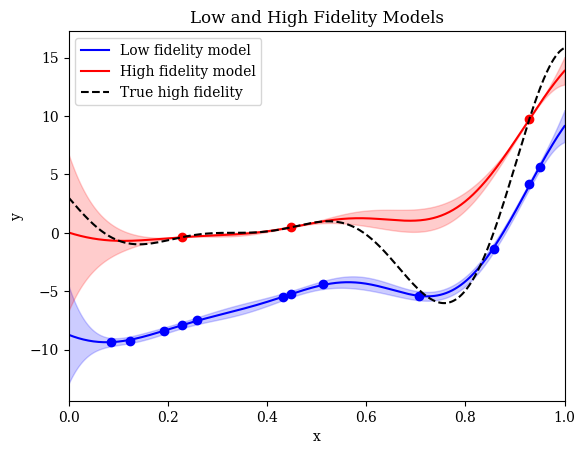

In [267]:
mfgp = multifidelityGPR(low_fidelity_toy, high_fidelity_toy)
n = np.array([12, 3])
mfgp.set_initial_data(12, 3, np.array([0, 1]))
mfgp.set_model()
mfgp.plot_model()
mfgp.set_acquisition(15, 10)
mfgp.init_bayes_loop()
mfgp.loop_plots(True, True)

In [269]:
# Loop events
GP_mean_h_list =[]
GP_mean_l_list=[]
GP_variance_h_list=[]
GP_variance_l_list=[]
Xlist = []
xnew_list=[]
ylist = []
ynew_list=[]
    
mfgp.set_loop_events([mfgp.best_solution, mfgp.save_animation_data])

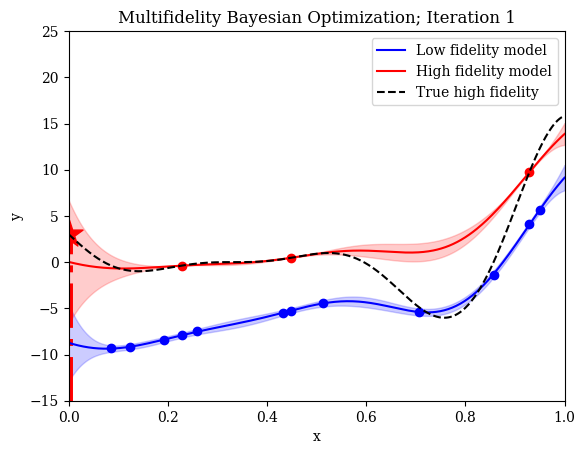

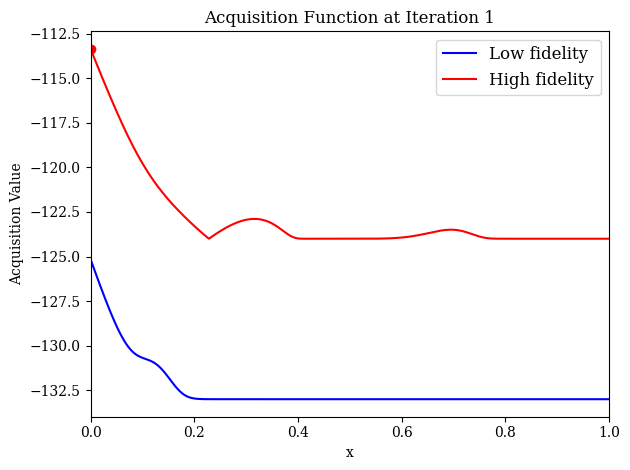

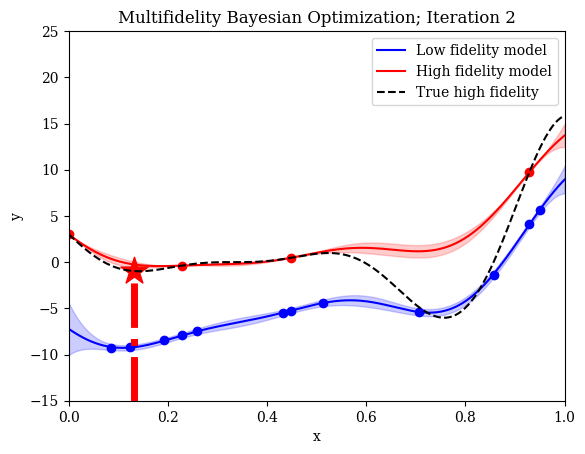

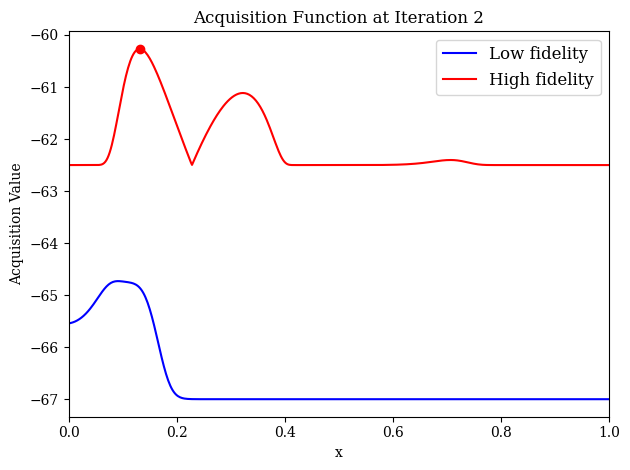

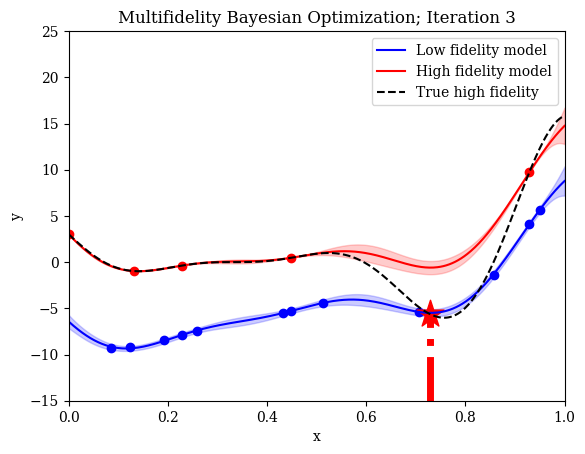

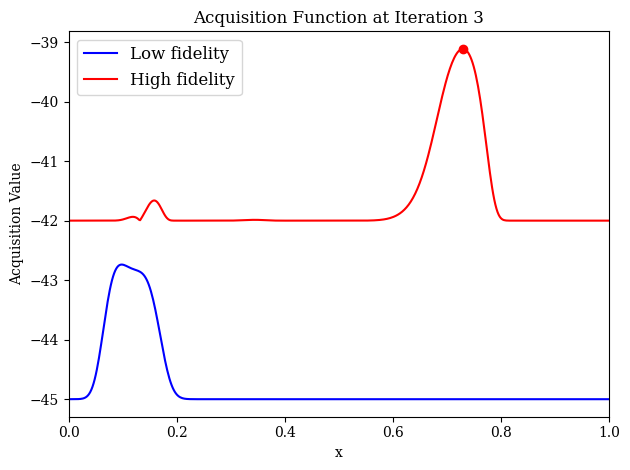

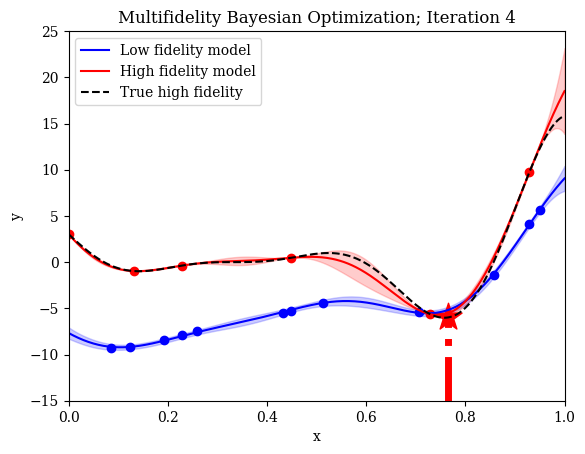

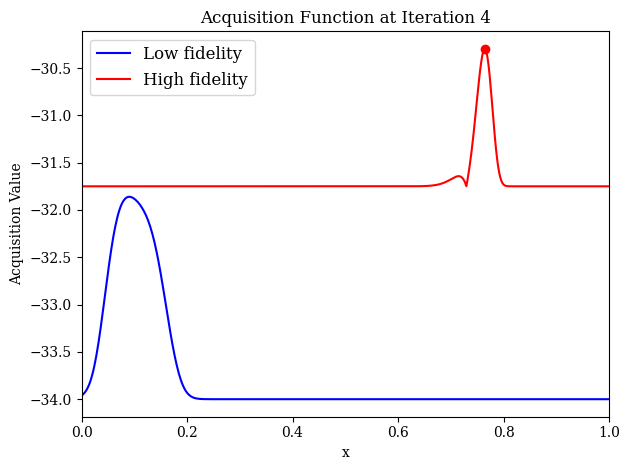

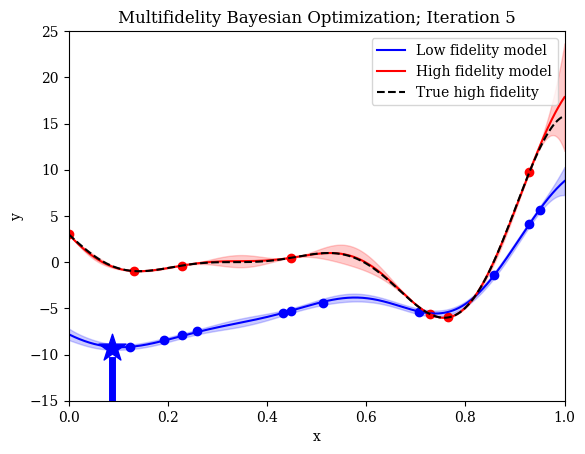

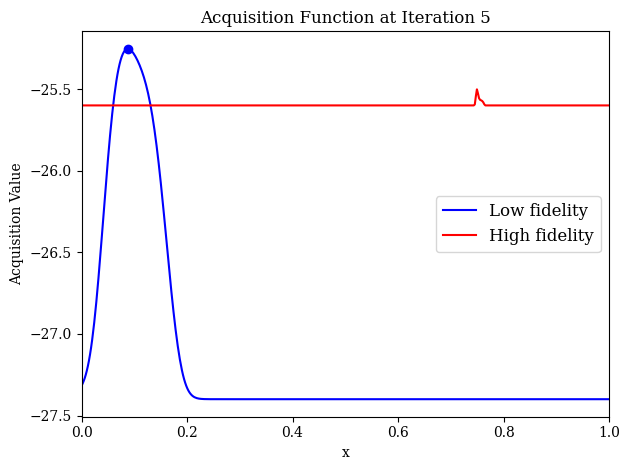

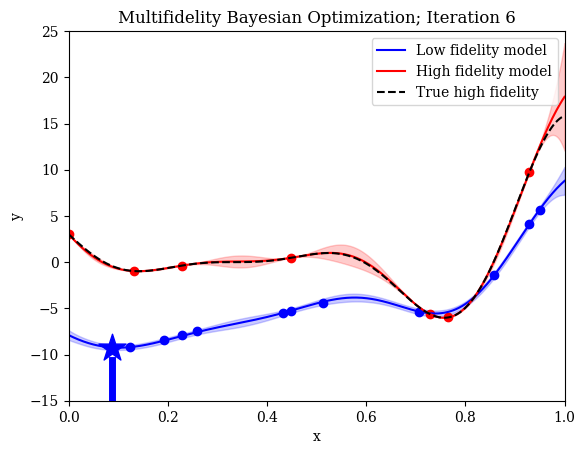

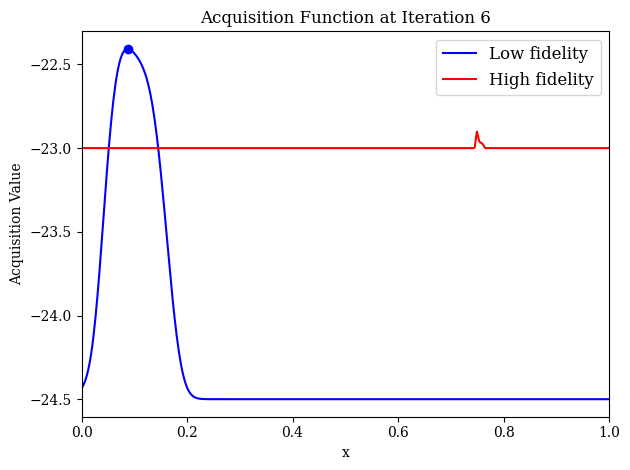

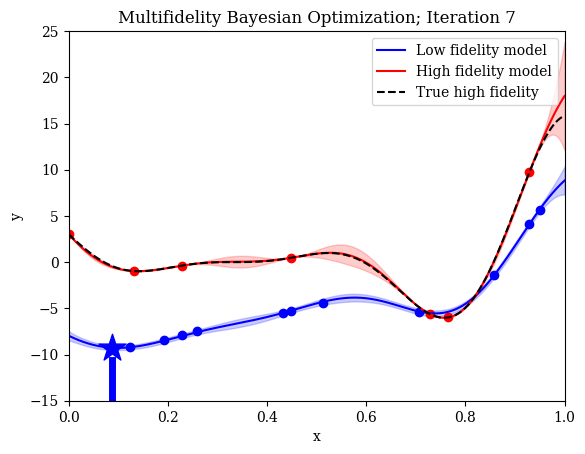

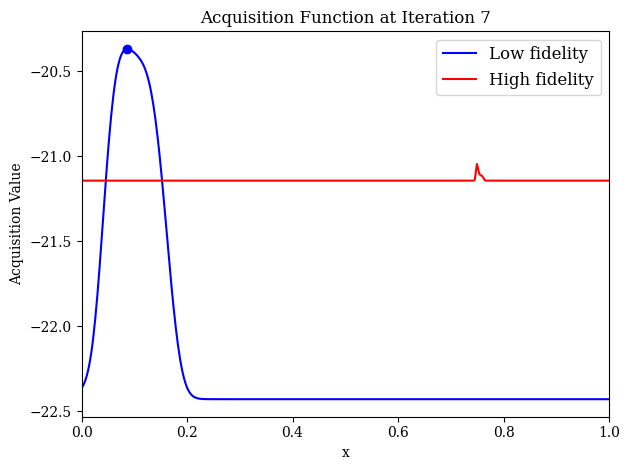

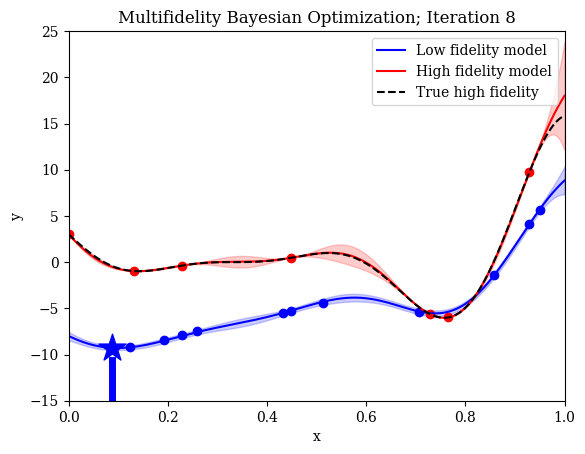

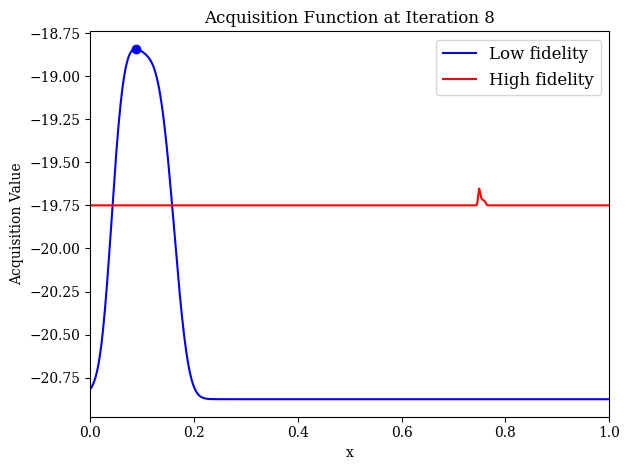

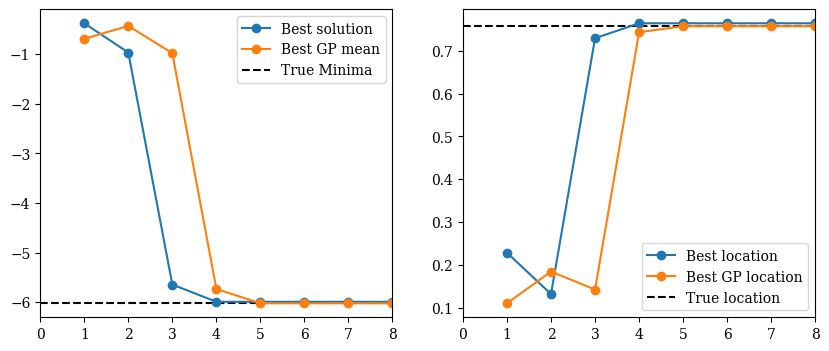

In [273]:
x, f = mfgp.run_bayes_loop(8, conv_plot=True)

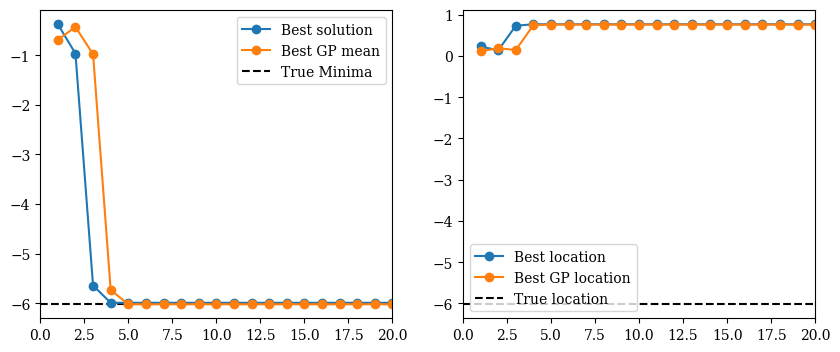

In [259]:
mfgp.plot_results()

In [7]:
# Define Multi-fidelity function and wrap in emukit

from emukit.core.loop.user_function import MultiSourceFunctionWrapper

# Low and high fidelity functions
#def low_fidelity_toy(x):
#    return 0.5*((x*6-2.7)**2)*np.sin((x*6-2.5)*2)+(x-0.5)*10. - 5
def low_fidelity_toy(x):
    #return (0.5*((x*6-2)**2)*np.sin((x*6?-2)*2)) + 10*(x-0.5) - 5
    return 0.5*high_fidelity_toy(x) + 10*(x-0.5) -5

def high_fidelity_toy(x):
    return ((x*6-2)**2)*np.sin((x*6-2)*2)

# Wrap the function using MultiSourceFunctionWrapper
forrester_fcn = MultiSourceFunctionWrapper([low_fidelity_toy,
                                               high_fidelity_toy])

forrester_fcn_low = forrester_fcn.f[0]
forrester_fcn_high = forrester_fcn.f[1]

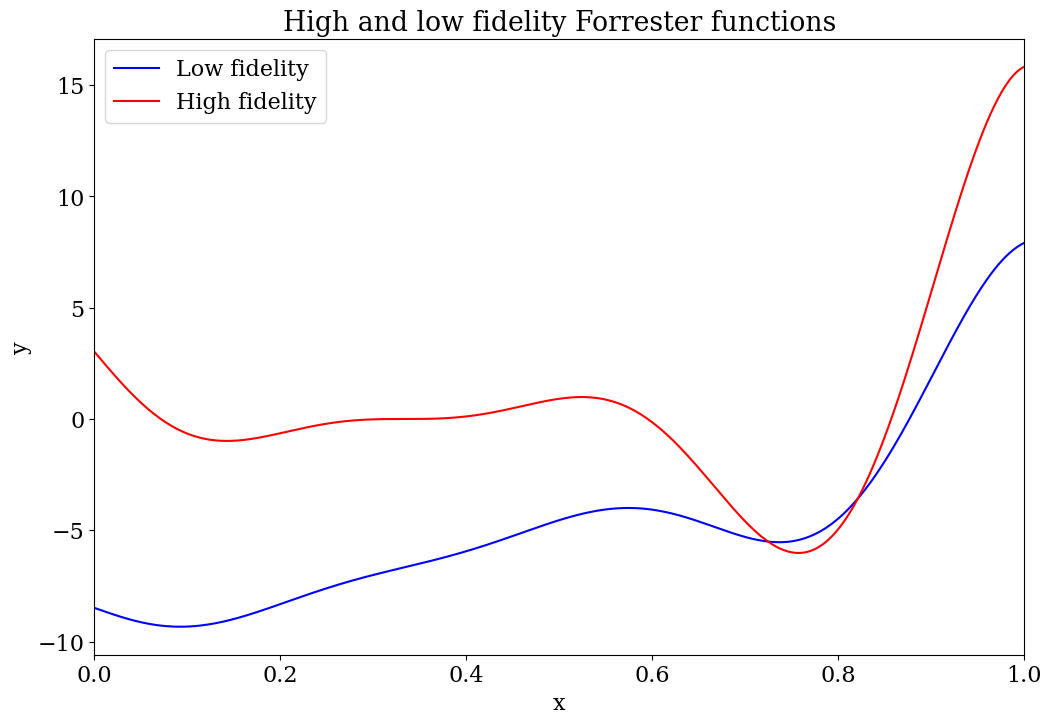

In [87]:
# Visualize fidelities
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
FIG_SIZE = (12, 8)
import numpy as np
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array

n_plot_points = 100
x_plot = np.linspace(0, 1, 500)[:, None]
y_plot_low = forrester_fcn_low(x_plot)
y_plot_high = forrester_fcn_high(x_plot)

plt.figure(figsize=FIG_SIZE)
plt.plot(x_plot, y_plot_low, 'b')
plt.plot(x_plot, y_plot_high, 'r')
plt.legend(['Low fidelity', 'High fidelity'])
plt.xlim(0, 1)
plt.title('High and low fidelity Forrester functions')
plt.xlabel('x')
plt.ylabel('y');
plt.show()

In [89]:
# Create initial dataset
np.random.seed(12346)
x_low = np.random.rand(12)[:, None]
x_high = x_low[:3, :]

n_init = len(x_low)+len(x_high)

y_low = forrester_fcn_low(x_low)
y_high = forrester_fcn_high(x_high)

In [91]:
# Search space

from emukit.core import ParameterSpace, ContinuousParameter, InformationSourceParameter
n_fidelities = 2

parameter_space = ParameterSpace([ContinuousParameter('x', 0, 1), InformationSourceParameter(n_fidelities)])

In [93]:
# Create autoregressive hierarchial GP model

from emukit.multi_fidelity.models.linear_model import GPyLinearMultiFidelityModel
import GPy
from emukit.multi_fidelity.kernels.linear_multi_fidelity_kernel import LinearMultiFidelityKernel
from emukit.multi_fidelity.convert_lists_to_array import convert_xy_lists_to_arrays
from emukit.model_wrappers import GPyMultiOutputWrapper
from GPy.models.gp_regression import GPRegression

x_array, y_array = convert_xy_lists_to_arrays([x_low, x_high], [y_low, y_high])

kern_low = GPy.kern.RBF(1)
kern_low.lengthscale.constrain_bounded(0.01, 0.5)

kern_err = GPy.kern.RBF(1)
kern_err.lengthscale.constrain_bounded(0.01, 0.5)

multi_fidelity_kernel = LinearMultiFidelityKernel([kern_low, kern_err])
gpy_model = GPyLinearMultiFidelityModel(x_array, y_array, multi_fidelity_kernel, n_fidelities)

gpy_model.likelihood.Gaussian_noise.fix(0.1)
gpy_model.likelihood.Gaussian_noise_1.fix(0)

model = GPyMultiOutputWrapper(gpy_model, 2, 5, verbose_optimization=False)
model.optimize()

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


In [95]:
x_array

array([[0.92899722, 0.        ],
       [0.44916575, 0.        ],
       [0.22831532, 0.        ],
       [0.70714404, 0.        ],
       [0.19195997, 0.        ],
       [0.85719177, 0.        ],
       [0.51332158, 0.        ],
       [0.0857998 , 0.        ],
       [0.25959895, 0.        ],
       [0.431627  , 0.        ],
       [0.95031458, 0.        ],
       [0.12427324, 0.        ],
       [0.92899722, 1.        ],
       [0.44916575, 1.        ],
       [0.22831532, 1.        ]])

In [97]:
gpy_model

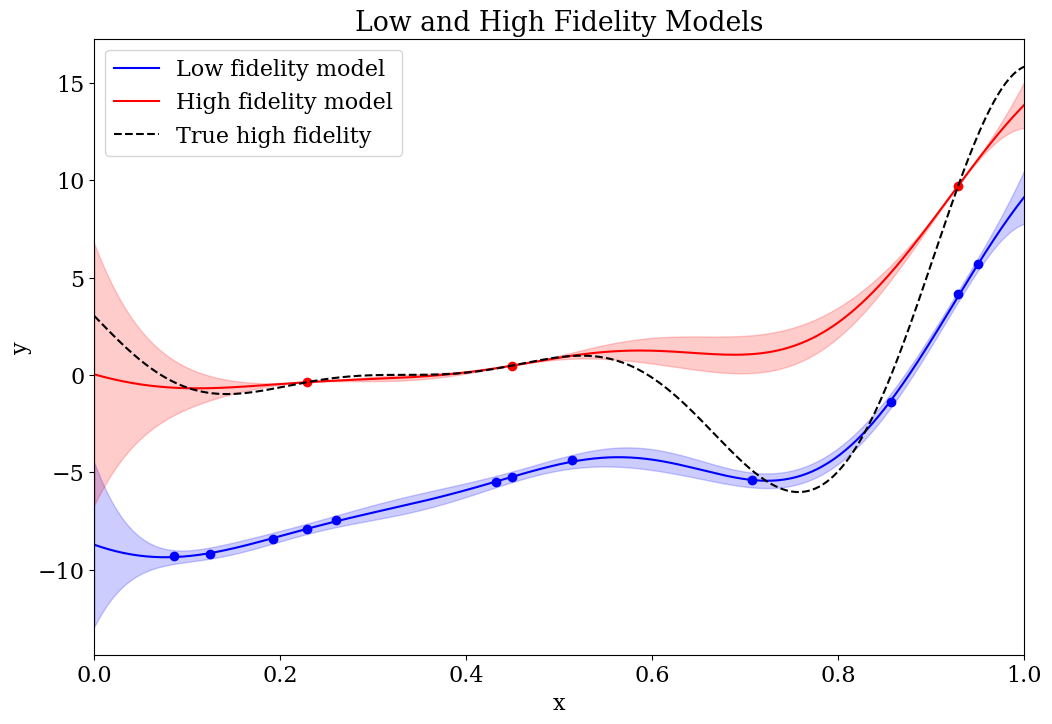

In [99]:
# Visualize model

x_plot_low = np.concatenate([np.atleast_2d(x_plot), np.zeros((x_plot.shape[0], 1))], axis=1)
x_plot_high = np.concatenate([np.atleast_2d(x_plot), np.ones((x_plot.shape[0], 1))], axis=1)


def plot_with_error_bars(x, mean, var, color):
    plt.plot(x, mean, color=color)
    plt.fill_between(x.flatten(), mean.flatten() - 1.96*var.flatten(), mean.flatten() + 1.96*var.flatten(), 
                    alpha=0.2, color=color)


def plot_model(x_low, y_low, x_high, y_high):
    mean_low, var_low = model.predict(x_plot_low)
    mean_high, var_high = model.predict(x_plot_high)

    plt.figure(figsize=FIG_SIZE)
    def plot_with_error_bars(x, mean, var, color):
        plt.plot(x, mean, color=color)
        plt.fill_between(x.flatten(), mean.flatten() - 1.96*var.flatten(), mean.flatten() + 1.96*var.flatten(), 
                        alpha=0.2, color=color)

    plot_with_error_bars(x_plot_high[:, 0], mean_low, var_low, 'b')
    plot_with_error_bars(x_plot_high[:, 0], mean_high, var_high, 'r')
    plt.plot(x_plot, forrester_fcn_high(x_plot), 'k--')
    plt.scatter(x_low, y_low, color='b')
    plt.scatter(x_high, y_high, color='r')
    plt.legend(['Low fidelity model', 'High fidelity model', 'True high fidelity'])
    plt.title('Low and High Fidelity Models')
    plt.xlim(0, 1)
    plt.xlabel('x')
    plt.ylabel('y');
    plt.show()
    
plot_model(x_low, y_low, x_high, y_high)

In [101]:
# Define custom acquisition model

from emukit.core.acquisition import Acquisition
from emukit.core.interfaces import IModel
import numpy as np
from scipy.stats import norm


class CustomMultiFidelityAcquisition(Acquisition):
    def __init__(self, model: IModel, space, cost_ratio=1/5):
        """
        Custom acquisition function for multi-fidelity optimization.

        :param model: Multi-fidelity model (e.g., a multi-fidelity GP)
        :param space: Search space over which the optimization is performed
        :param cost_function: Optional cost function that assigns a cost to each fidelity level
        """
        super().__init__()
        self.model = model  # Multi-fidelity GP model
        self.space = space  # The parameter space (search space)
        self.cost_ratio = cost_ratio  # Optional cost ratio
    
    @property
    def has_gradients(self):
        # If gradients are implemented, return True. Otherwise, return False.
        return False

    def evaluate(self, x: np.ndarray):
        """
        Evaluate the custom acquisition function at the given points.

        :param x: Input points to evaluate (np.ndarray of shape (n_points, input_dim))
        :return: Acquisition values (np.ndarray of shape (n_points,))
        """
        # Multi-fidelity model's prediction (mean, variance) at point x
        mean, variance = self.model.predict(x)

        if x[0][1] == 0:
            best_so_far = np.min(self.model.Y[self.model.X[:, 1] == 0])
        if x[0][1] == 1:
            best_so_far = np.min(self.model.Y[self.model.X[:, 1] == 1])

        # This can be modified to include more sophisticated information-based criteria
        acquisition_value = self._expected_improvement(mean, variance, best_so_far) - self._cost_function(x)
        return acquisition_value

    def _expected_improvement(self, mean, variance, best_so_far):
        """
        Custom Expected Improvement calculation.

        :param mean: Predicted mean from the GP model
        :param variance: Predicted variance from the GP model
        :return: Expected Improvement (np.ndarray)
        """
        improvement = best_so_far - mean
        z = improvement / np.sqrt(variance)
        ei = improvement * norm.cdf(z) + 15*(np.sqrt(variance) * norm.pdf(z))
        ei[ei == 0] = np.zeros(ei[ei == 0].shape)   
        return ei

    def _cost_function(self, x):
        b = self.cost_ratio
        n1 = sum(model.X[:, 1] == 0) # LF points
        n2 = sum(model.X[:, 1] == 1) # HF points
        
        if x[0][1] == 0:
            cost = b*(n1+ 1) + n2
        if x[0][1] == 1:
            cost = b*n1 + (n2+1)
        return cost/(1+len(self.model.X)-n_init)
    
    def evaluate_with_gradients(self, x: np.ndarray):
        """
        Evaluate the custom acquisition function and return gradients.

        :param x: Input points to evaluate (np.ndarray of shape (n_points, input_dim))
        :return: Tuple of (acquisition values, gradients)
        """
        raise NotImplementedError("Gradients are not implemented for this acquisition function.")

In [103]:
acquisition = CustomMultiFidelityAcquisition(model, parameter_space, 10)

In [105]:
from emukit.core.loop import FixedIntervalUpdater, OuterLoop, SequentialPointCalculator
from emukit.core.loop.loop_state import create_loop_state
from emukit.core.optimization.multi_source_acquisition_optimizer import MultiSourceAcquisitionOptimizer
from emukit.core.optimization import GradientAcquisitionOptimizer

initial_loop_state = create_loop_state(x_array, y_array)
acquisition_optimizer = MultiSourceAcquisitionOptimizer(GradientAcquisitionOptimizer(parameter_space), parameter_space)
candidate_point_calculator = SequentialPointCalculator(acquisition, acquisition_optimizer)
model_updater = FixedIntervalUpdater(model)
loop = OuterLoop(candidate_point_calculator, model_updater, initial_loop_state)

In [107]:
def plot_acquisition(loop, loop_state):
    colours = ['b', 'r']
    plt.plot(x_plot_low[:, 0], loop.candidate_point_calculator.acquisition.evaluate(x_plot_low), 'b')
    plt.plot(x_plot_high[:, 0], loop.candidate_point_calculator.acquisition.evaluate(x_plot_high), 'r')
    
    previous_x_collected = loop_state.X[[-1], :]
    fidelity_idx = int(previous_x_collected[0, -1])
    plt.scatter(previous_x_collected[0, 0], 
                loop.candidate_point_calculator.acquisition.evaluate(previous_x_collected), 
                color=colours[fidelity_idx])
    plt.legend(['Low fidelity', 'High fidelity'], fontsize=12)
    plt.title('Acquisition Function at Iteration ' + str(loop_state.iteration))
    plt.xlabel('x')
    plt.xlim(0, 1)
    plt.ylabel('Acquisition Value')
    plt.tight_layout()
    plt.show()

def plot_with_error_bars(x, mean, var, color):
        plt.plot(x, mean, color=color)
        plt.fill_between(x.flatten(), mean.flatten() - 1.96*var.flatten(), mean.flatten() + 1.96*var.flatten(), 
                        alpha=0.2, color=color)

def plot_optimization(loop, loop_state):
    colours = ['b', 'r']
    is_high_fidelity = loop.loop_state.X[:, -1] == 1
    x_low=loop.loop_state.X[~is_high_fidelity, 0]
    y_low=loop.loop_state.Y[~is_high_fidelity]
    x_high=loop.loop_state.X[is_high_fidelity, 0]
    y_high=loop.loop_state.Y[is_high_fidelity]

    mean_low, var_low = model.predict(x_plot_low)
    mean_high, var_high = model.predict(x_plot_high)

    plt.figure(figsize=FIG_SIZE)
    plot_with_error_bars(x_plot_high[:, 0], mean_low, var_low, 'b')
    plot_with_error_bars(x_plot_high[:, 0], mean_high, var_high, 'r')
    plt.plot(x_plot, forrester_fcn_high(x_plot), 'k--')
    plt.scatter(x_low, y_low, color='b')
    plt.scatter(x_high, y_high, color='r')

    xnew = loop_state.X[[-1], :]
    fidelity_idx = int(xnew[0, -1])
    ynew = forrester_fcn.f[fidelity_idx](xnew[0,0])
    plt.scatter(xnew[0, 0], 
                ynew, 
                color=colours[fidelity_idx], marker='*', s=420)
    
    plt.vlines(xnew[0,0], -15, ynew, linestyle='-.', linewidth=5, color=colours[fidelity_idx])
    
    plt.legend(['Low fidelity model', 'High fidelity model', 'True high fidelity'])
    plt.title('Low and High Fidelity Models')
    plt.xlim(0, 1)
    plt.ylim(-15,25)
    plt.xlabel('x')
    plt.ylabel('y');
    plt.show()


GP_mean_h_list =[]
GP_mean_l_list=[]
GP_variance_h_list=[]
GP_variance_l_list=[]
Xlist = []
xnew_list=[]
ylist = []
ynew_list=[]
    

def animation_data(loop, loop_state):
    is_high_fidelity = loop.loop_state.X[:, -1] == 1
    x_low=loop.loop_state.X[~is_high_fidelity, 0]
    y_low=loop.loop_state.Y[~is_high_fidelity]
    x_high=loop.loop_state.X[is_high_fidelity, 0]
    y_high=loop.loop_state.Y[is_high_fidelity]

    mean_low, var_low = model.predict(x_plot_low)
    mean_high, var_high = model.predict(x_plot_high)

    xnew = loop_state.X[[-1], :]
    fidelity_idx = int(xnew[0, -1])
    ynew = forrester_fcn.f[fidelity_idx](xnew[0,0])
    
    GP_mean_h_list.append(mean_high)
    GP_mean_l_list.append(mean_low)
    GP_variance_h_list.append(var_high)
    GP_variance_l_list.append(var_low)
    Xlist.append(loop.loop_state.X)
    xnew_list.append(xnew)
    ylist.append(loop.loop_state.Y)
    ynew_list.append(ynew)
    
loop.iteration_end_event.append(plot_optimization)
loop.iteration_end_event.append(plot_acquisition)
loop.iteration_end_event.append(animation_data)

In [109]:
x_search = np.stack([np.linspace(0, 1, 1000), np.ones(1000)], axis=1)

model_min_mean = []
model_min_loc = []
def calculate_metrics(loop, loop_state):
    mean, var = loop.model_updaters[0].model.predict(x_search)
    model_min_mean.append(np.min(mean))
    model_min_loc.append(x_search[np.argmin(mean), 0])

# subscribe to event
loop.iteration_end_event.append(calculate_metrics)

In [1056]:
model_min_mean

[-0.691266051097419,
 -0.43131506562318017,
 -0.9812099704543011,
 -5.734259876526619,
 -6.023280349792577,
 -6.020465755867517,
 -6.020596950429172,
 -6.020603994197031,
 -6.020606607735649,
 -6.020606372729262,
 -6.020606257217496,
 -6.02060618830805,
 -6.020606146127914,
 -6.02060611825388,
 -6.020606097819192,
 -6.020606084848372,
 -6.020606078282911,
 -6.020606069146427,
 -6.020606065098959,
 -6.020606064805088]

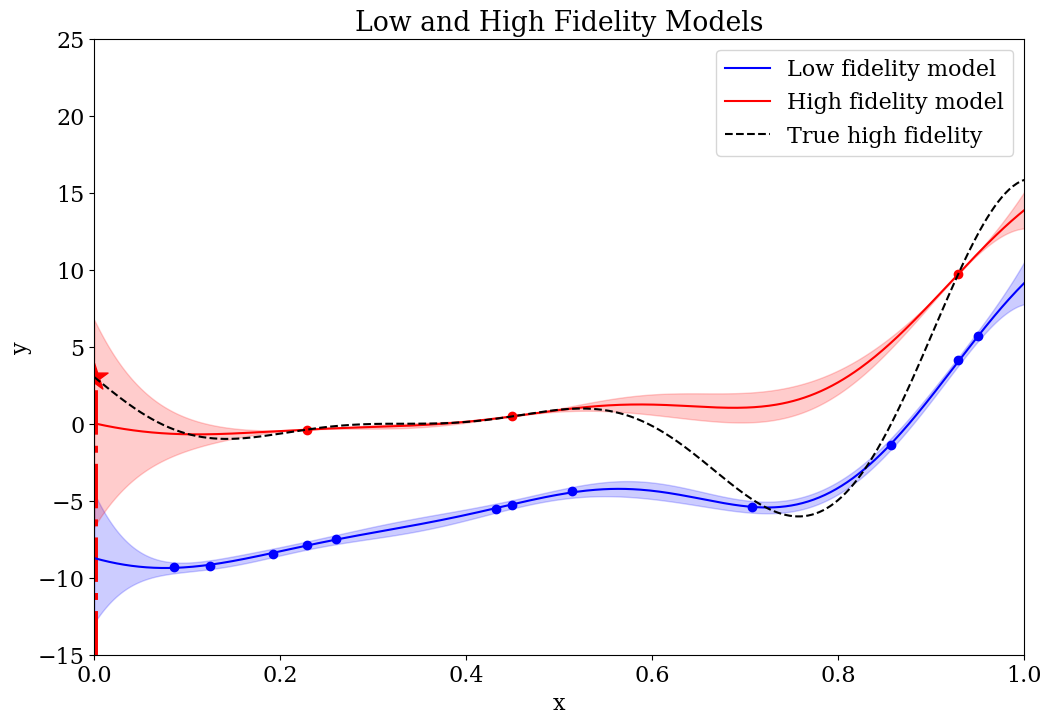

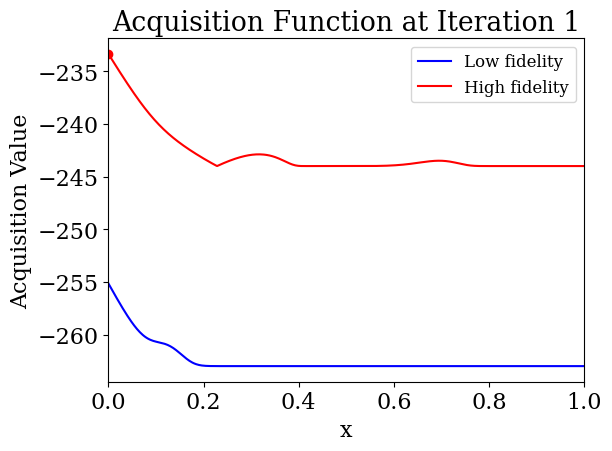

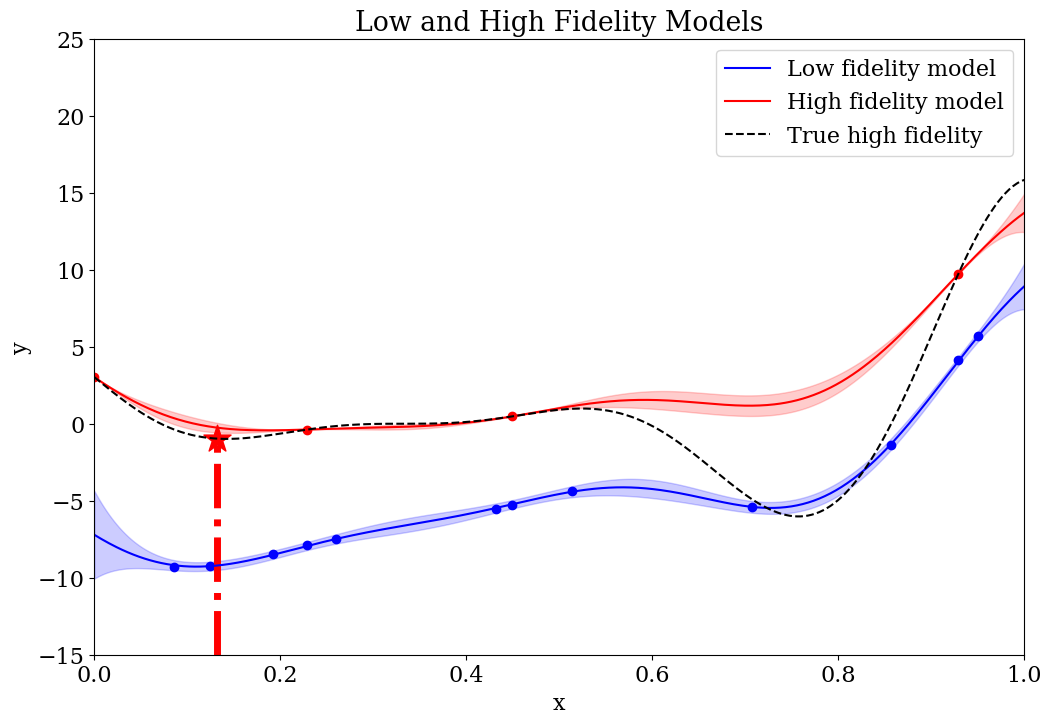

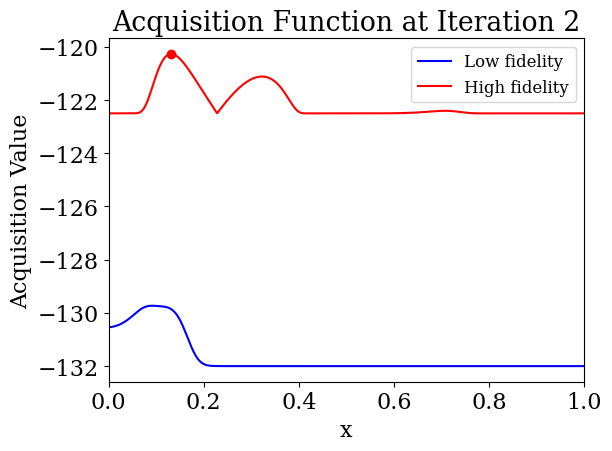

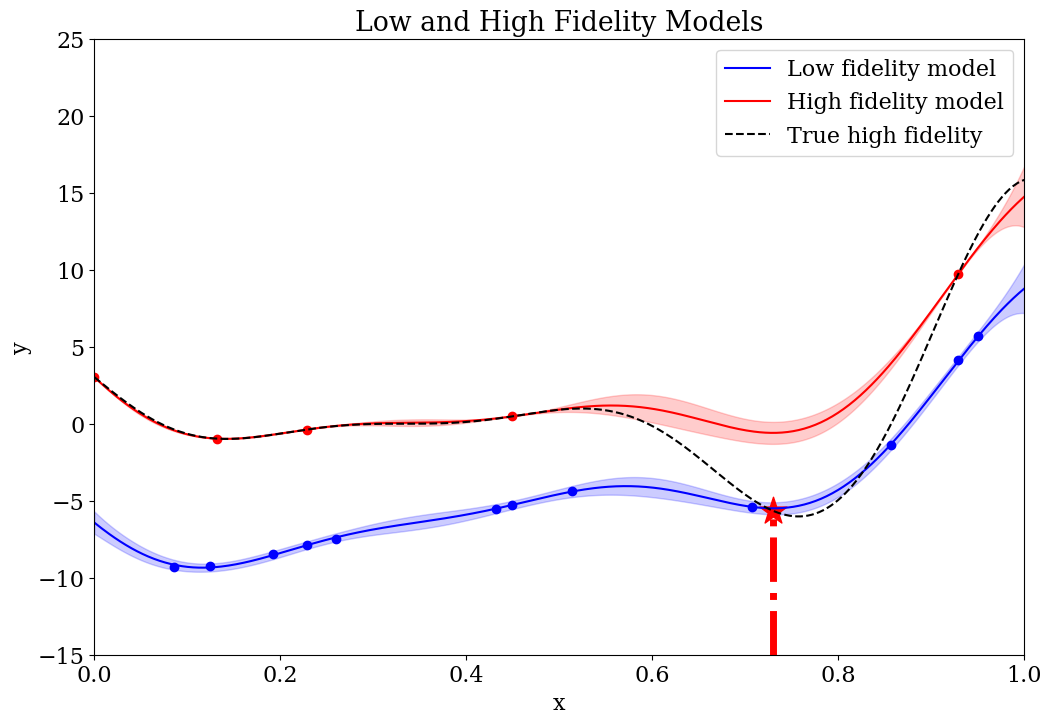

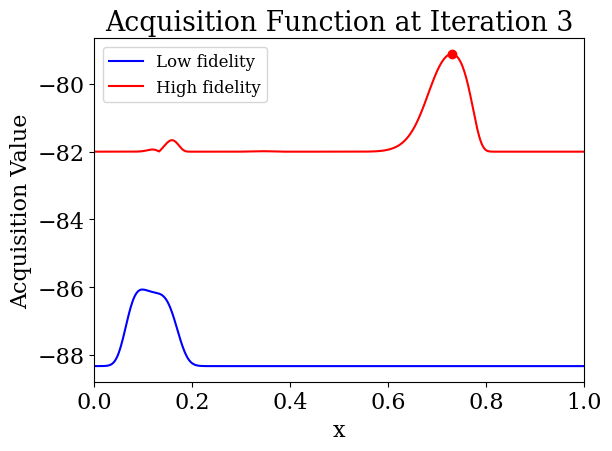

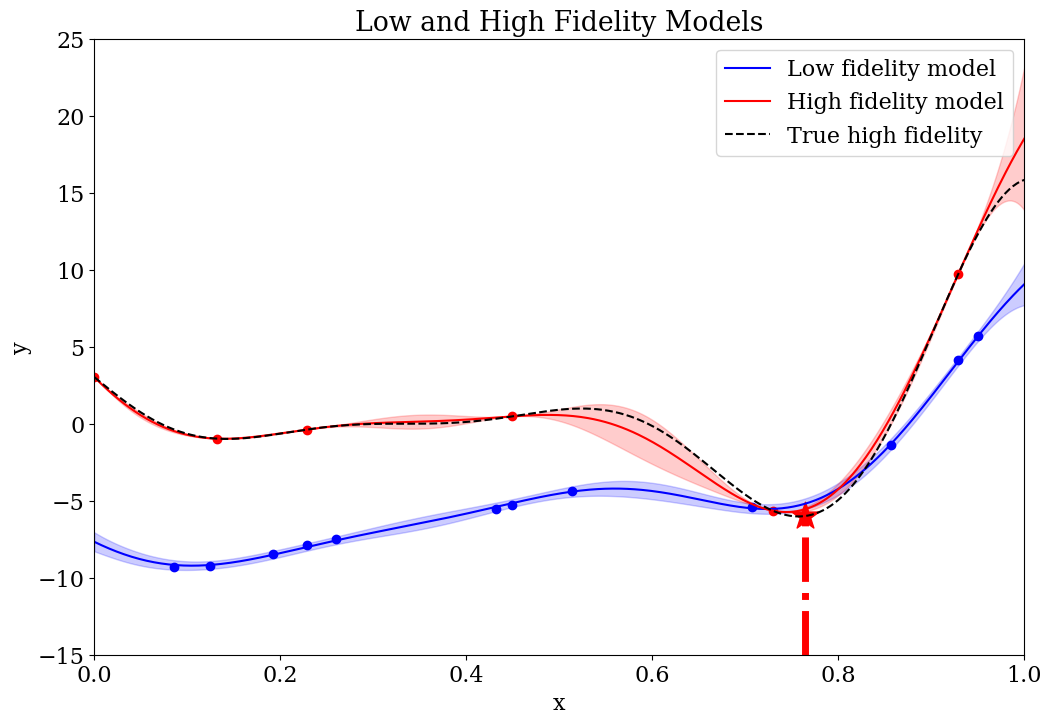

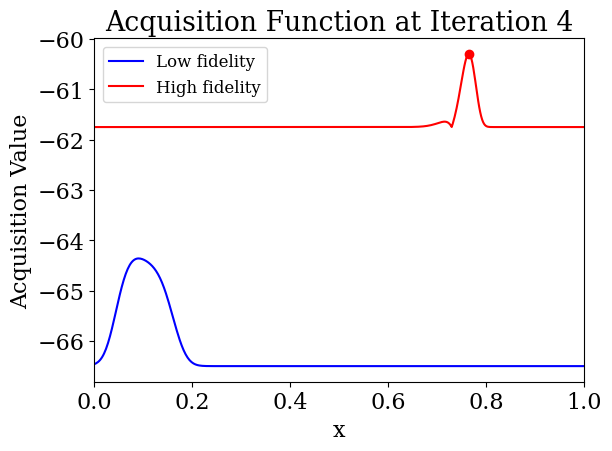

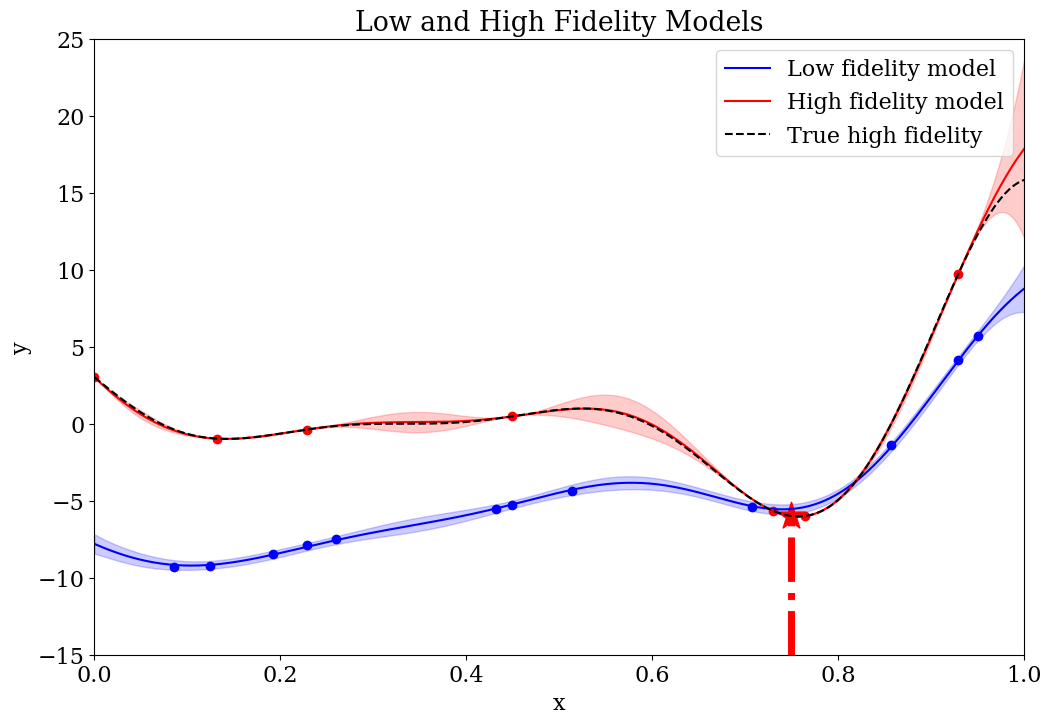

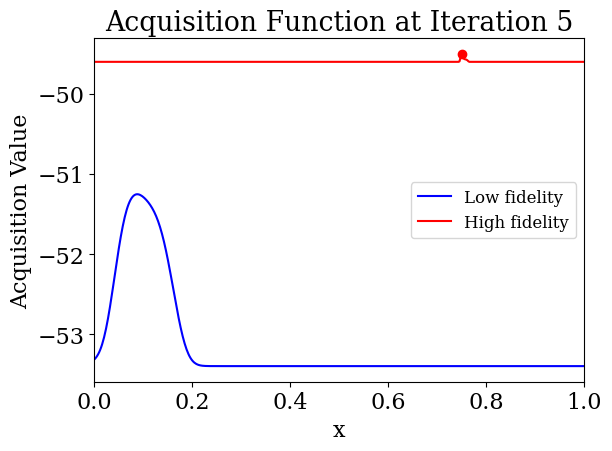

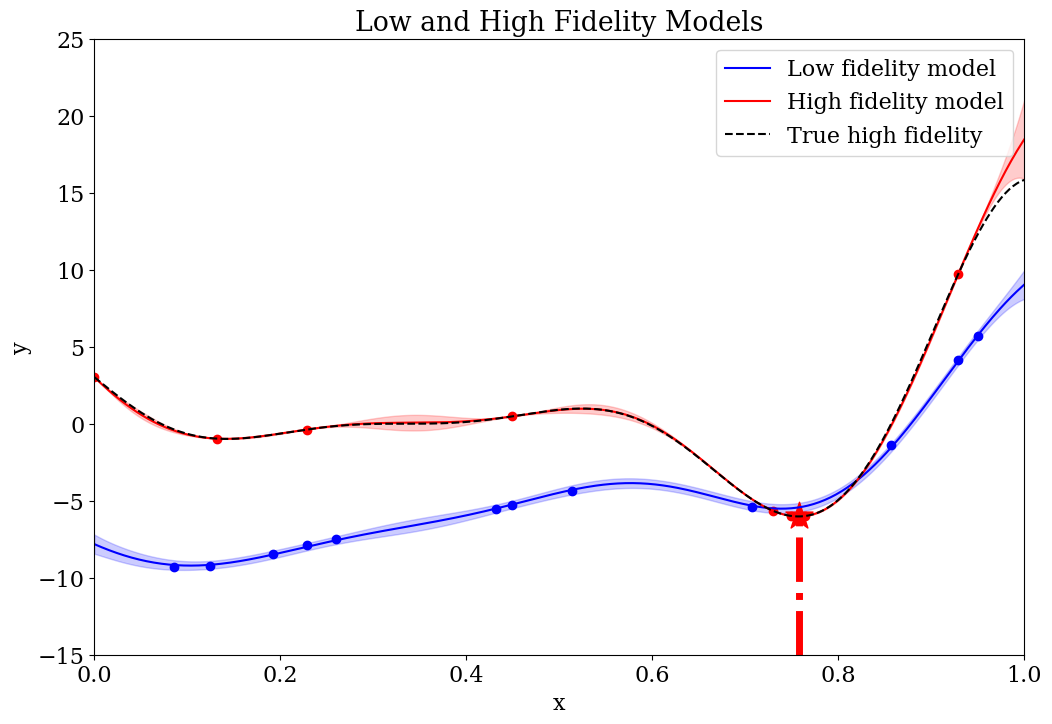

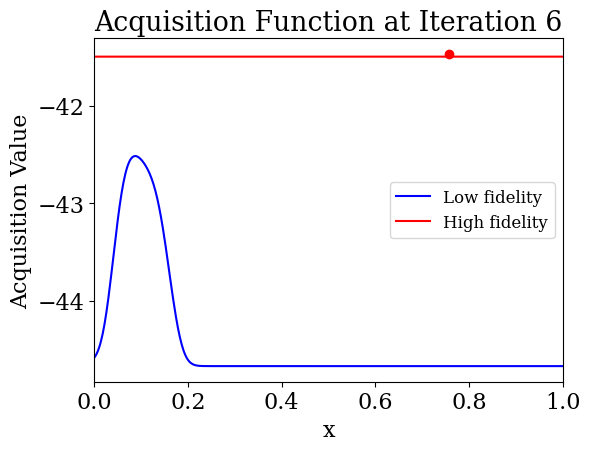

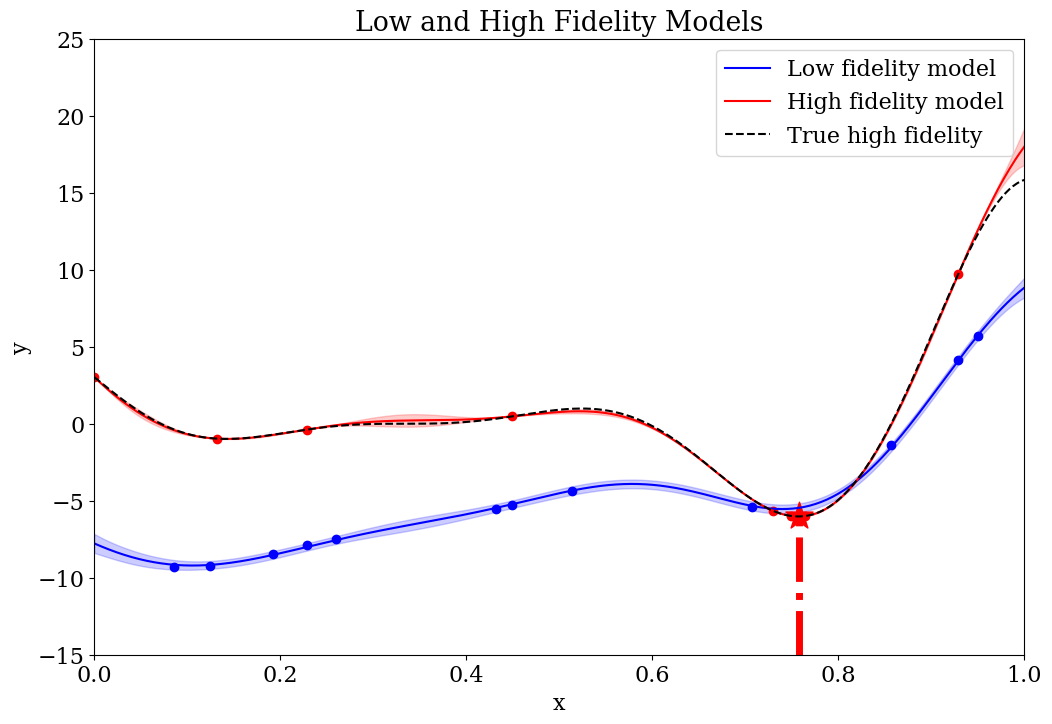

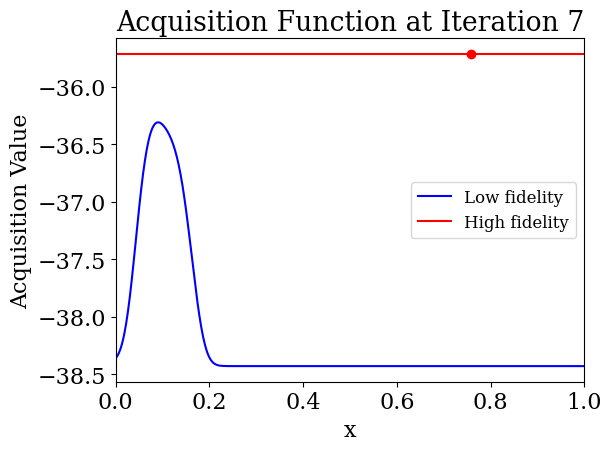

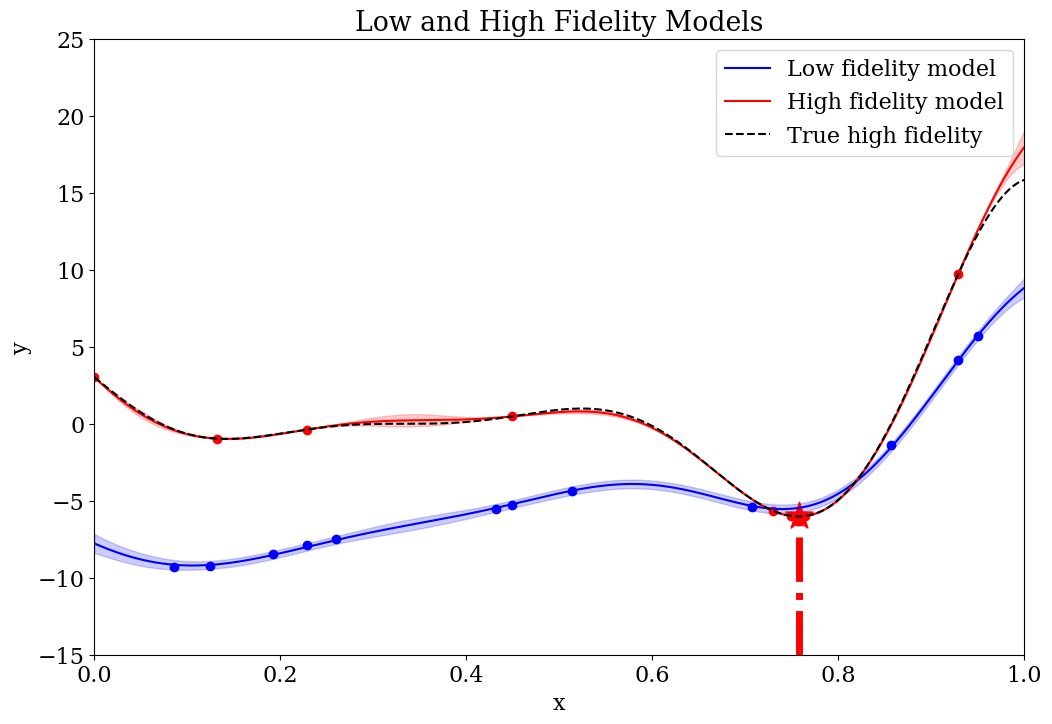

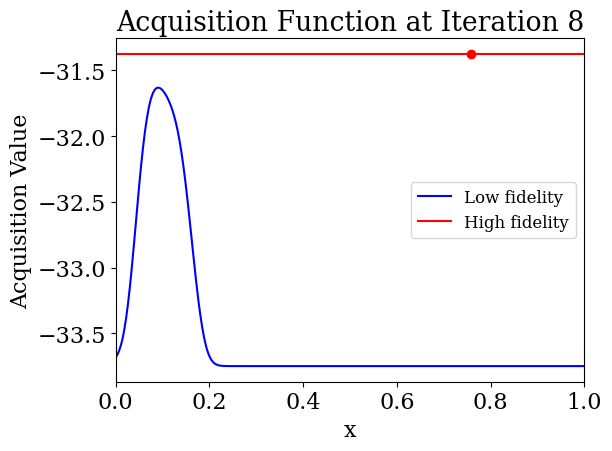

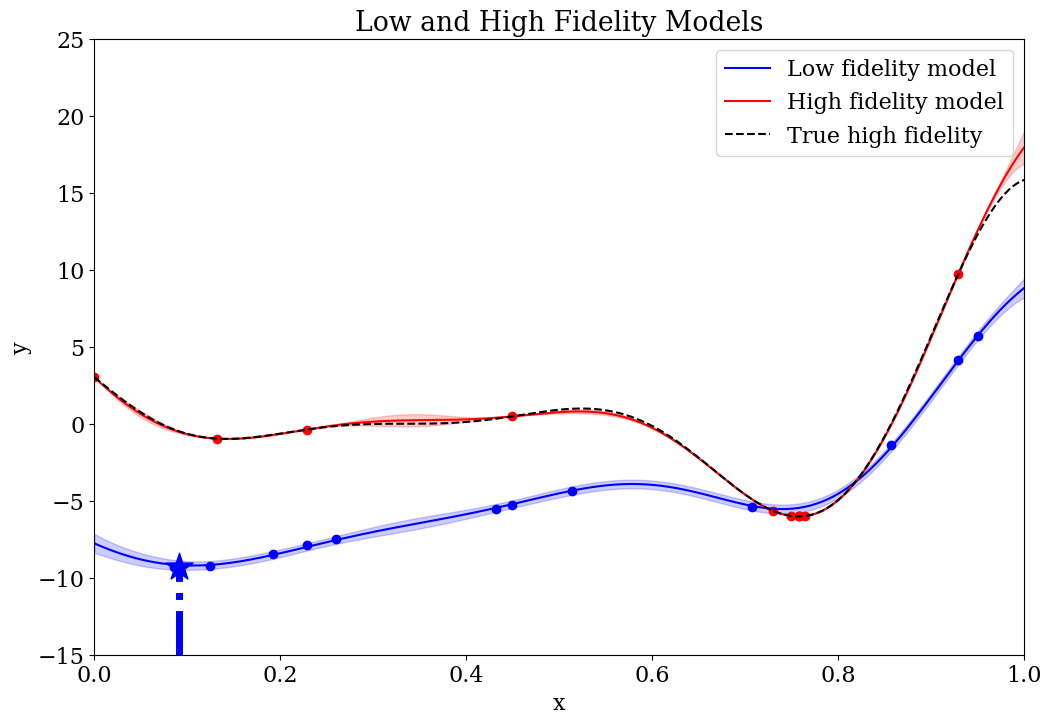

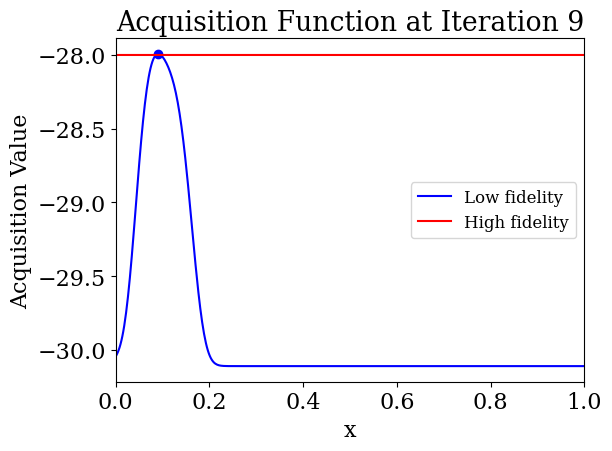

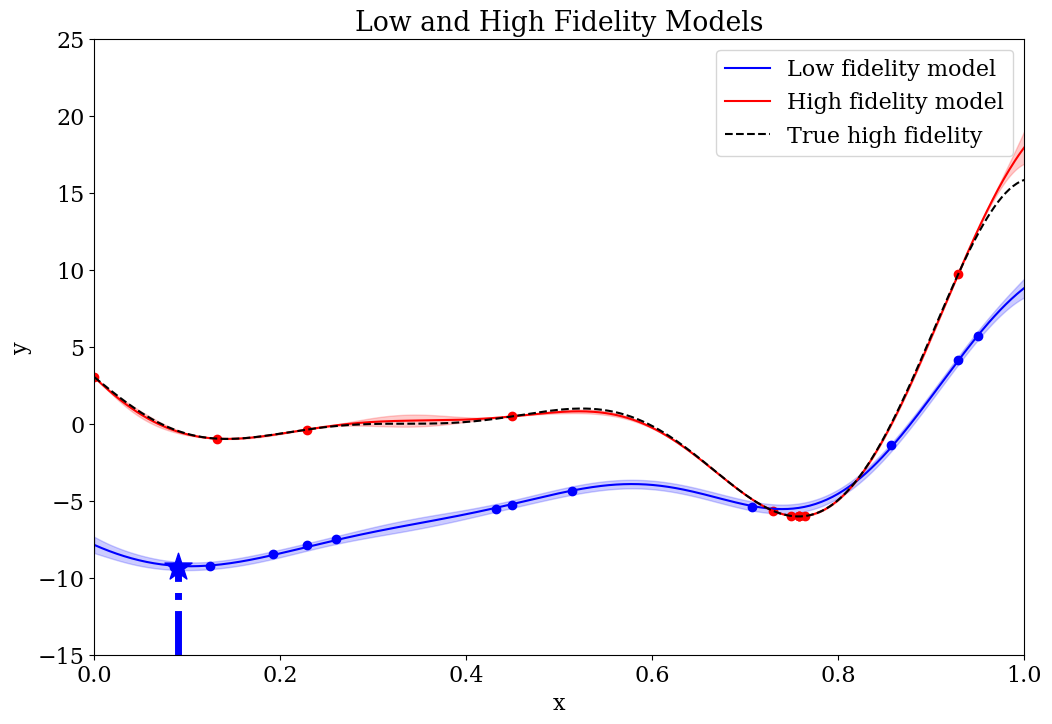

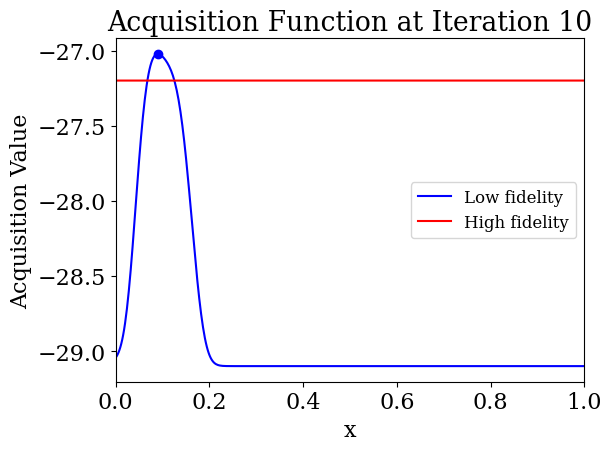

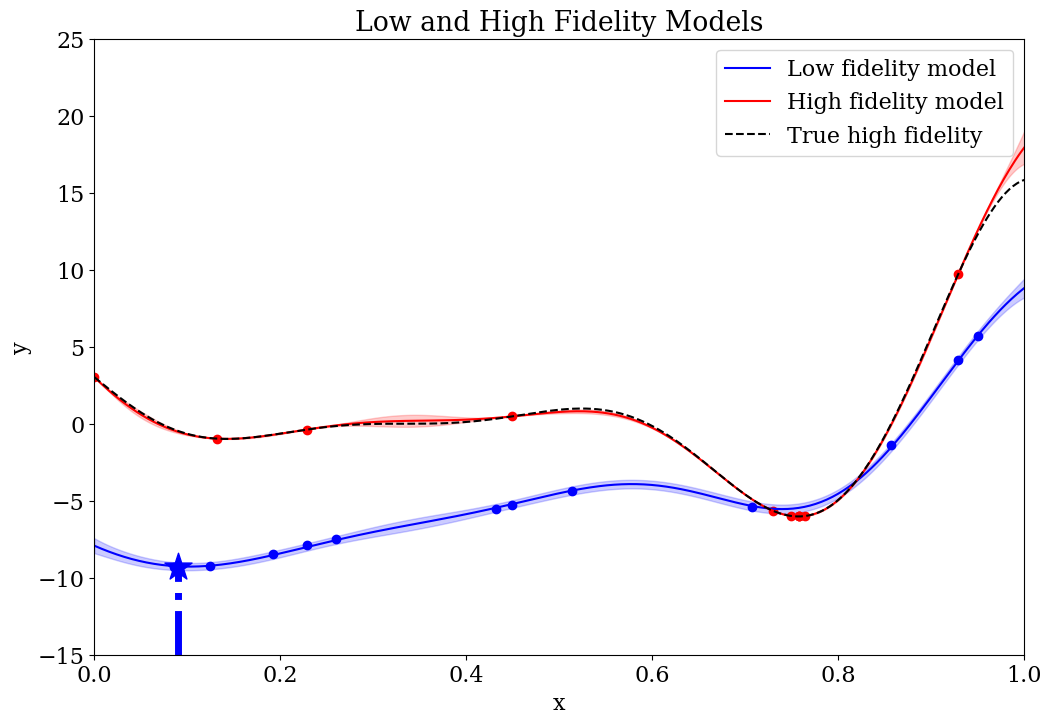

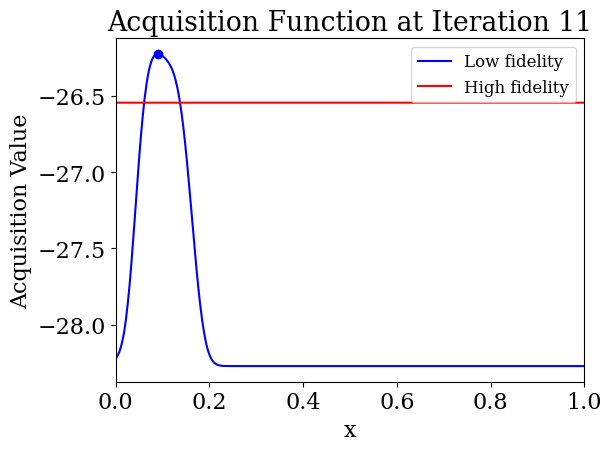

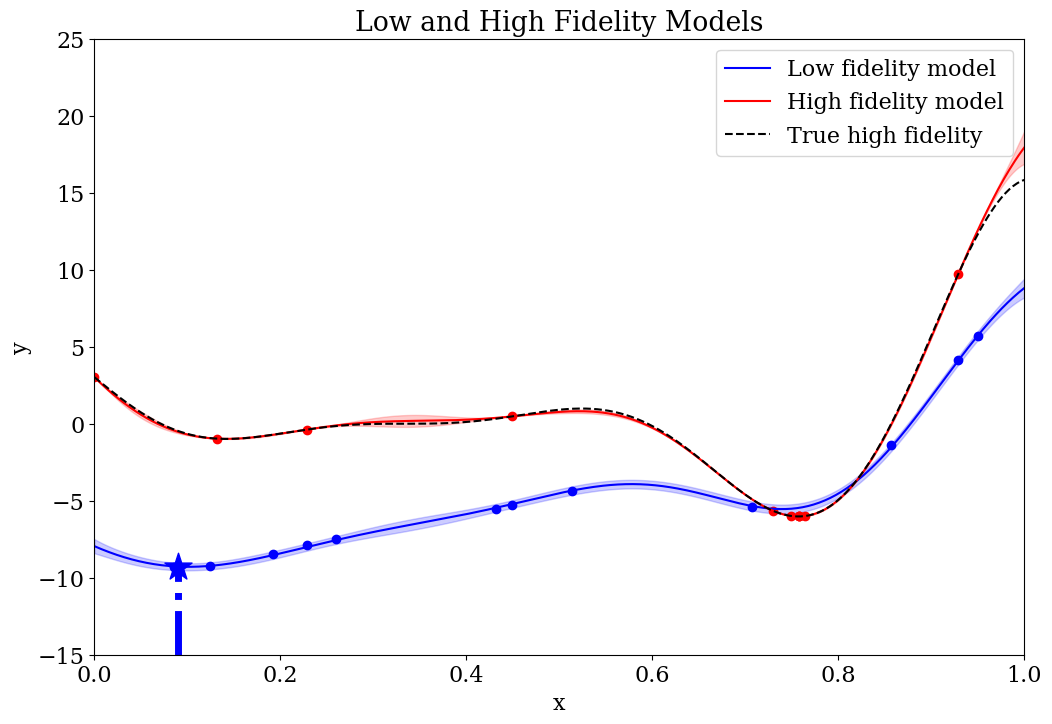

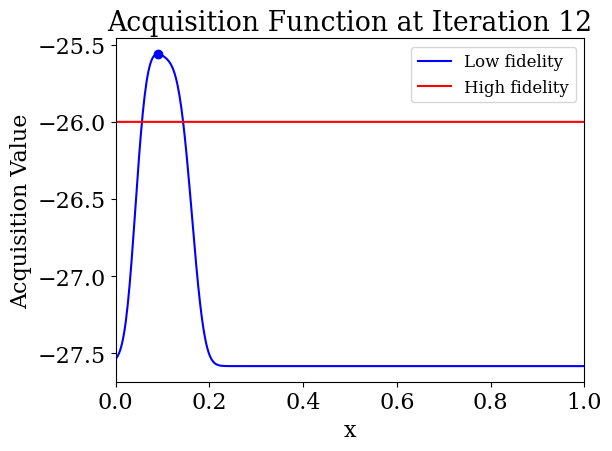

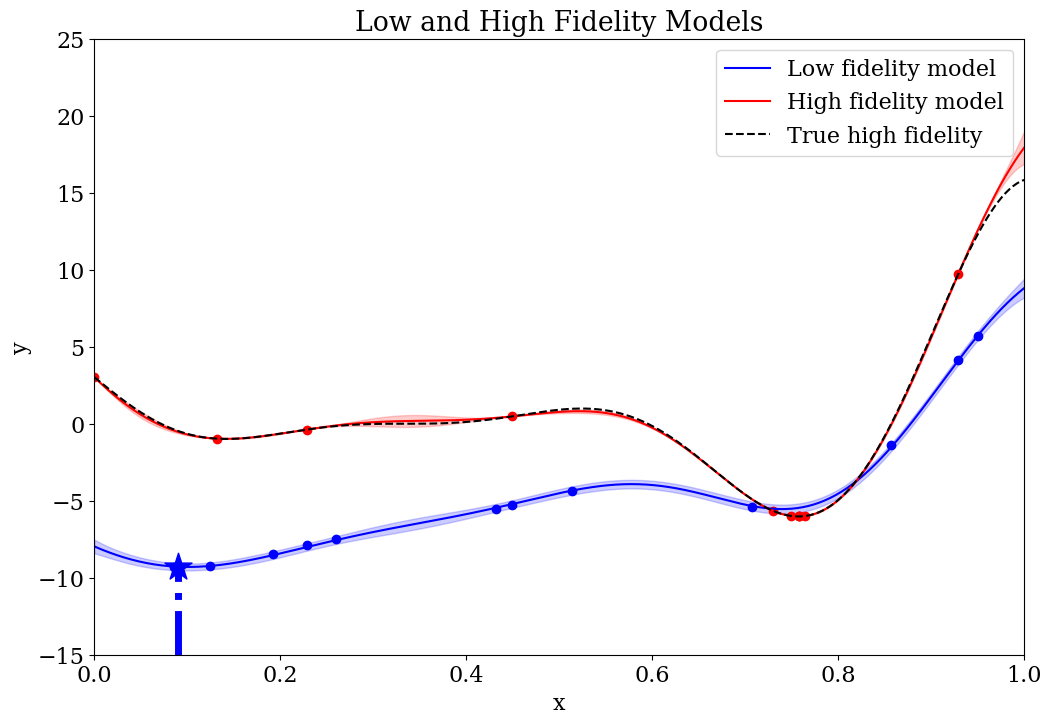

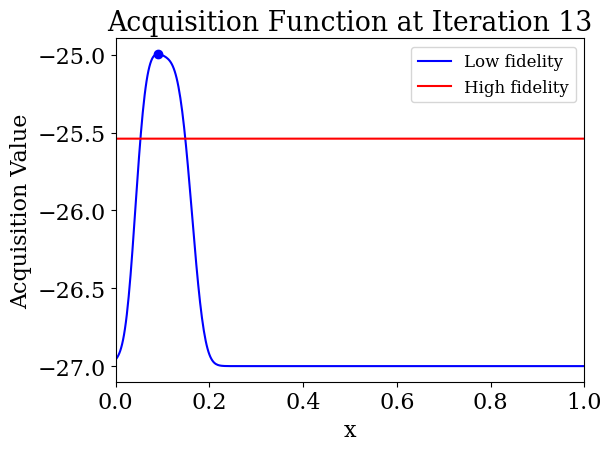

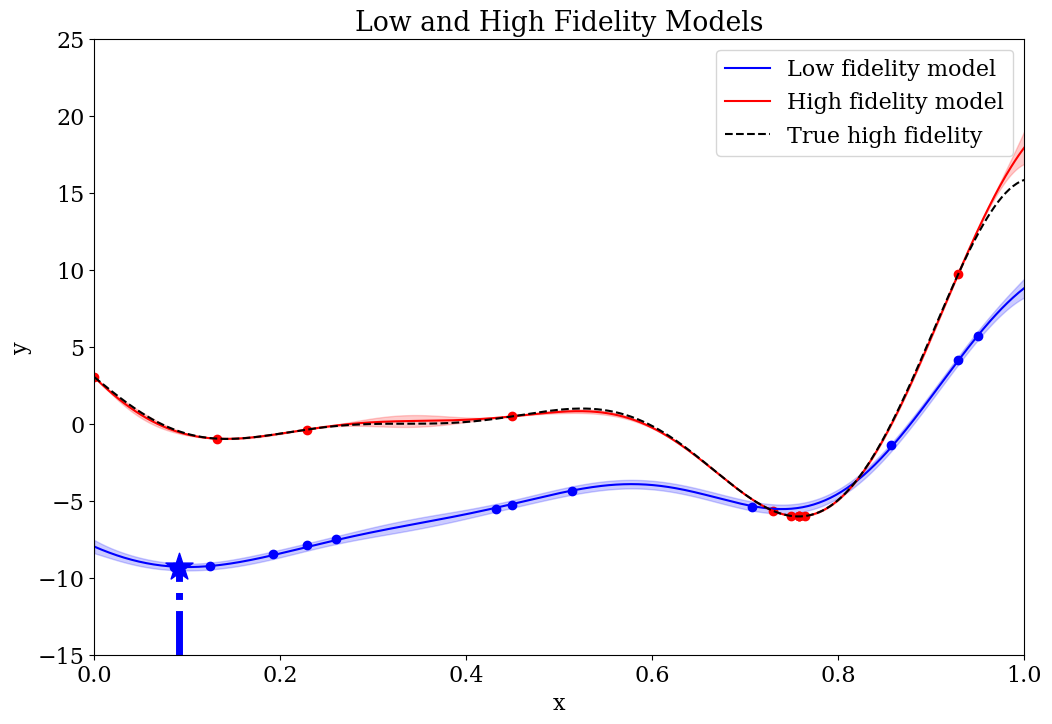

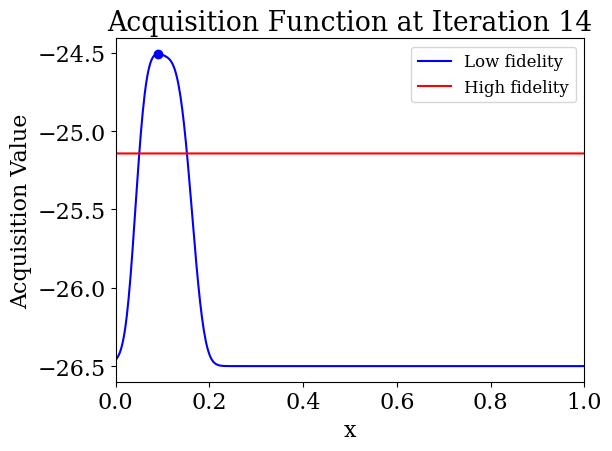

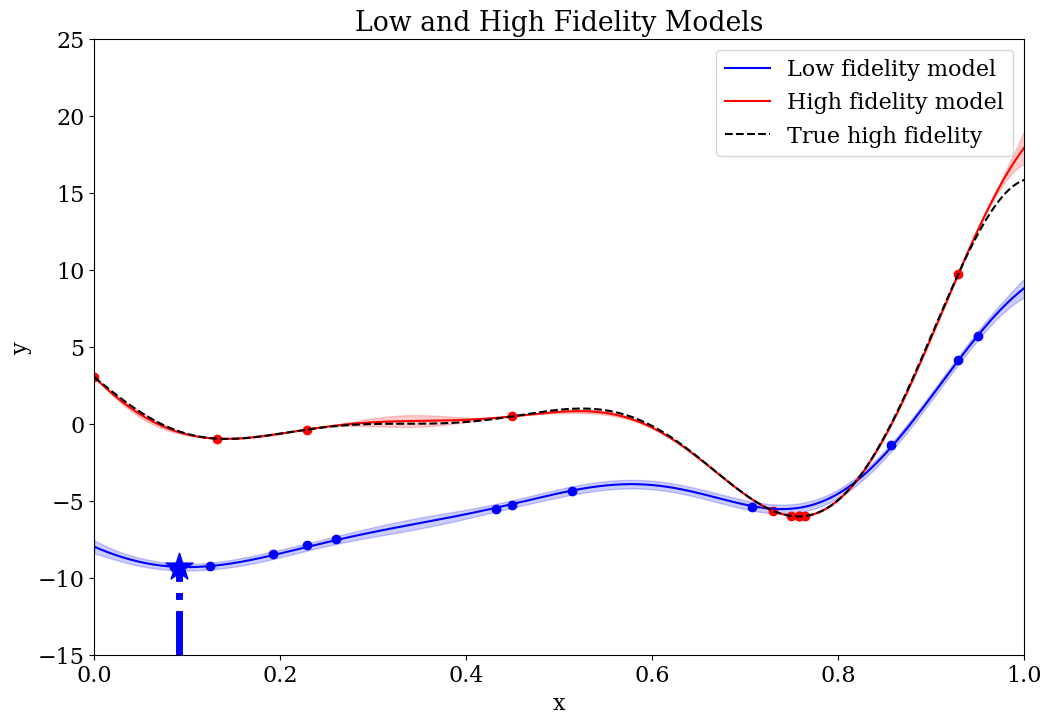

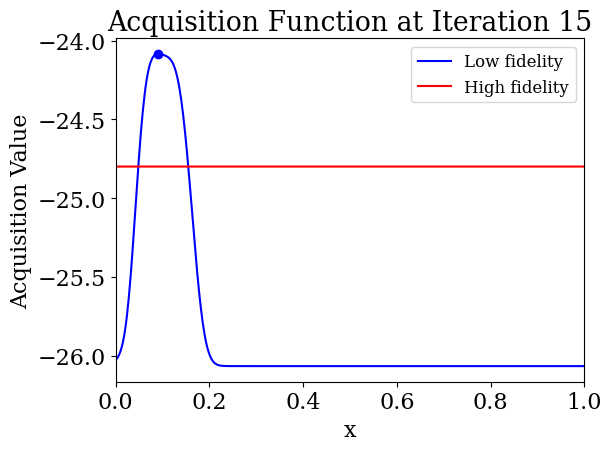

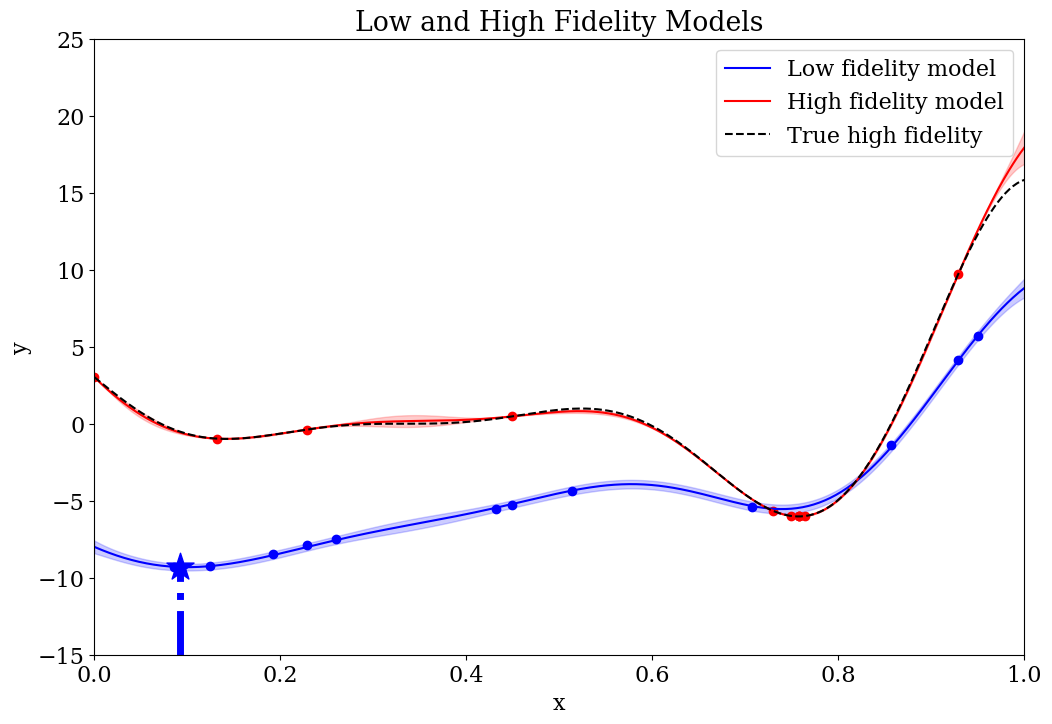

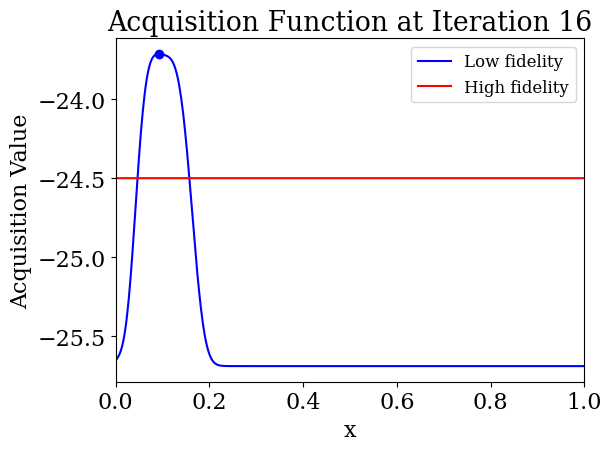

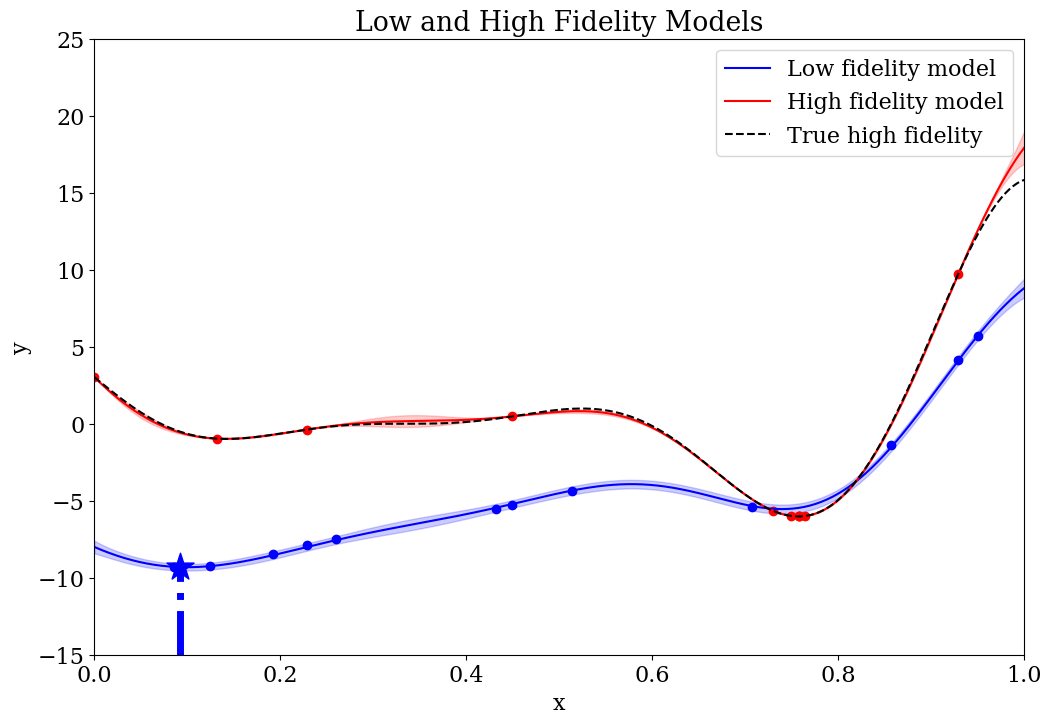

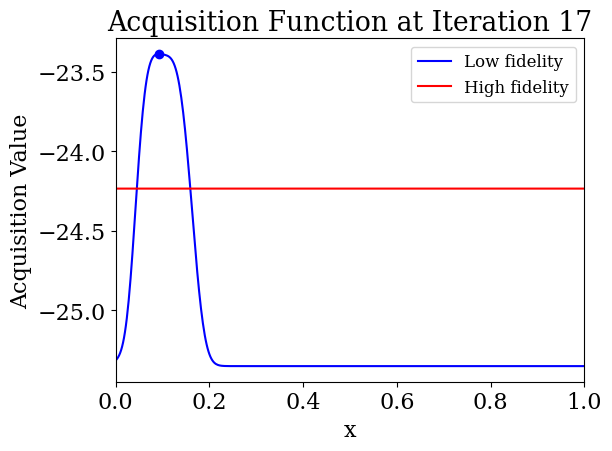

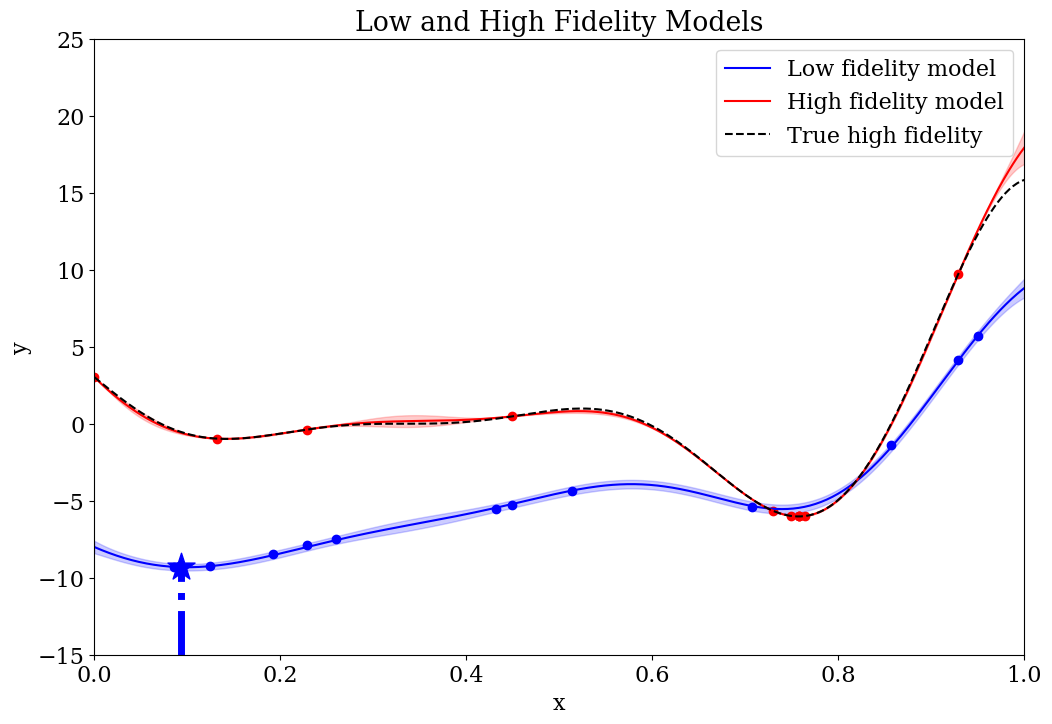

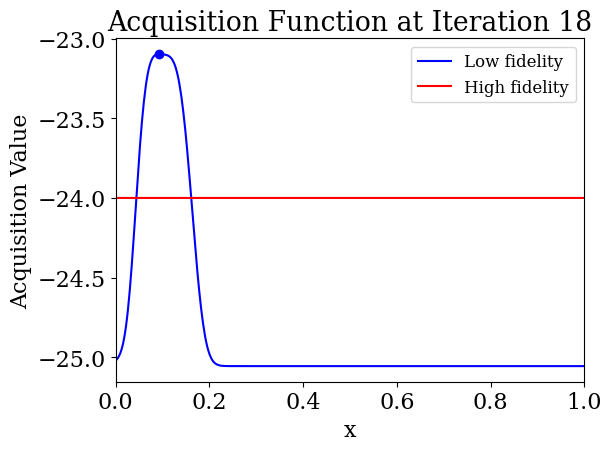

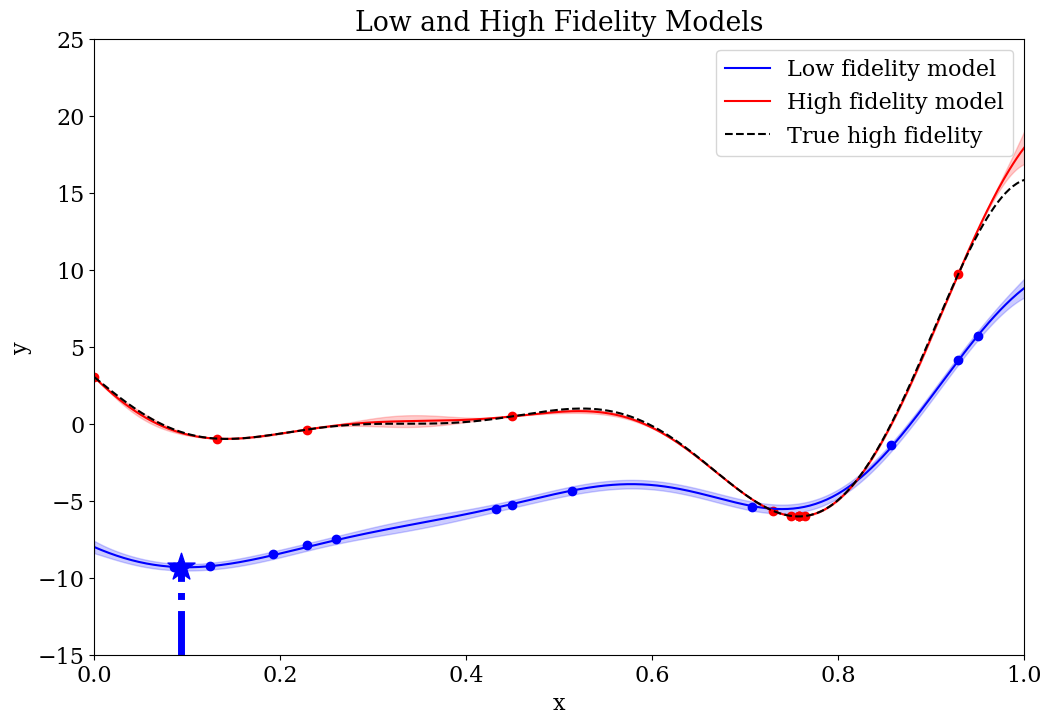

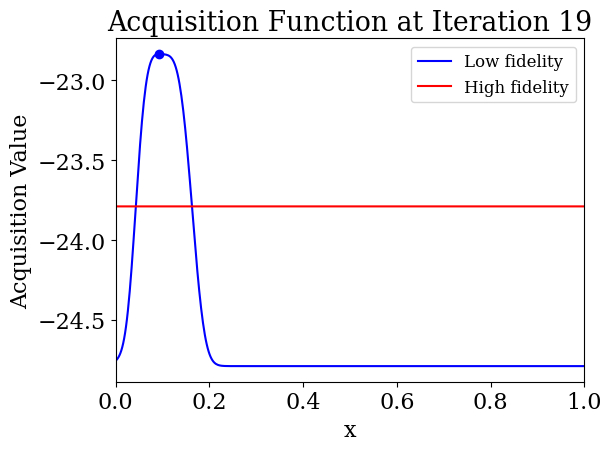

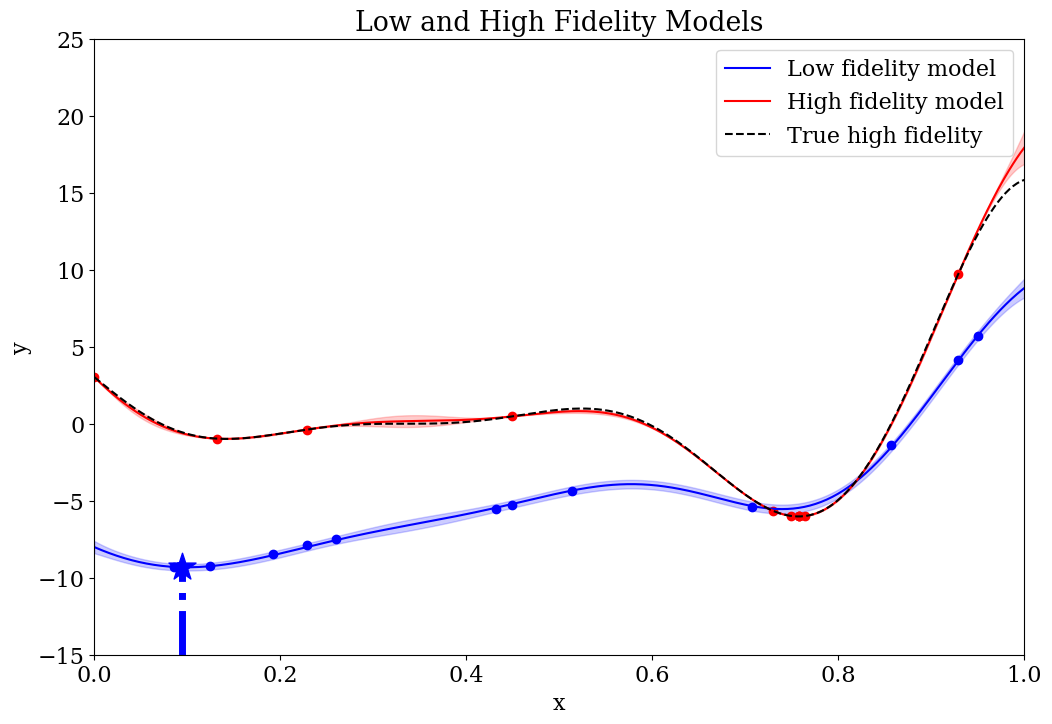

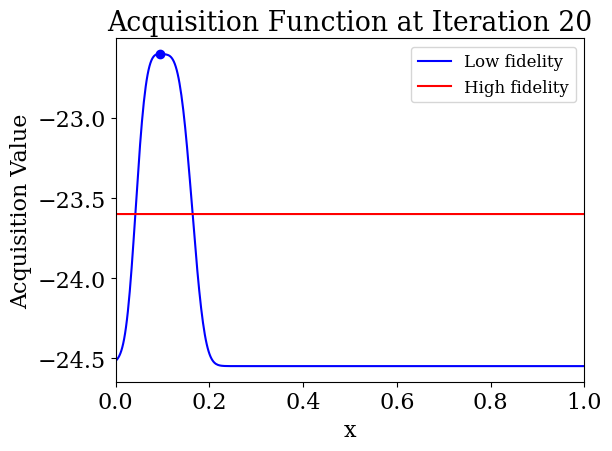

In [1006]:
loop.run_loop(forrester_fcn, 20)

In [113]:
candidate_point_calculator.compute_next_points(model)

array([[0., 1.]])

In [115]:
YY = np.concatenate([model.Y, forrester_fcn_high(candidate_point_calculator.compute_next_points(model).ravel()[:-1]).reshape(-1,1)])
XX = np.concatenate([model.X, candidate_point_calculator.compute_next_points(model)])

In [117]:
model.set_data(XX, YY)

In [119]:
model.optimize()

NameError: name 'loop_state' is not defined

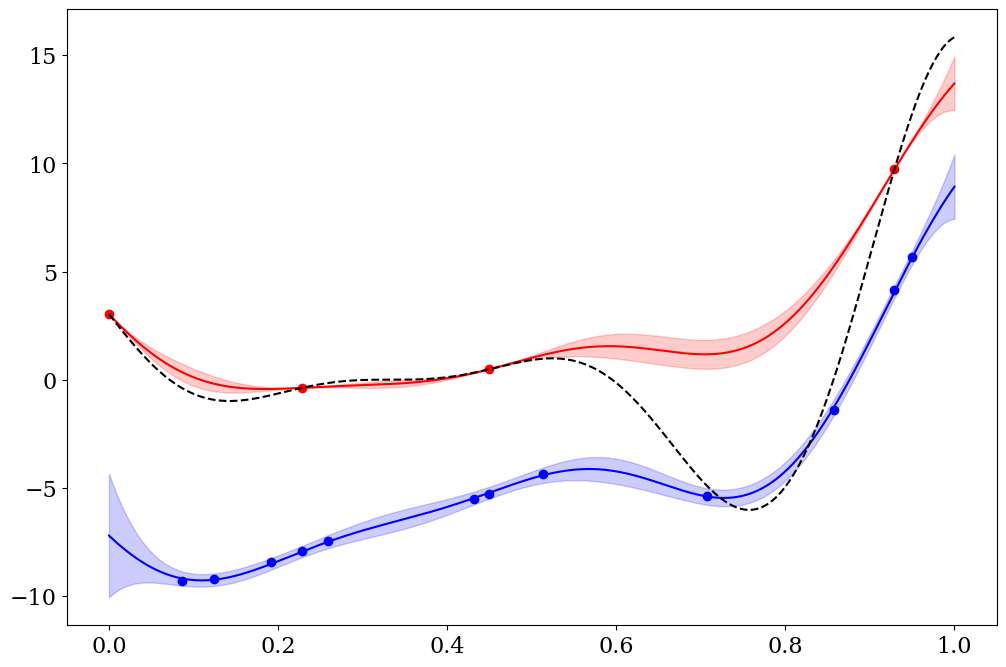

In [121]:
colours = ['b', 'r']
is_high_fidelity = model.X[:, -1] == 1
x_low=model.X[~is_high_fidelity, 0]
y_low=model.Y[~is_high_fidelity]
x_high=model.X[is_high_fidelity, 0]
y_high=model.Y[is_high_fidelity]

mean_low, var_low = model.predict(x_plot_low)
mean_high, var_high = model.predict(x_plot_high)

plt.figure(figsize=FIG_SIZE)
plot_with_error_bars(x_plot_high[:, 0], mean_low, var_low, 'b')
plot_with_error_bars(x_plot_high[:, 0], mean_high, var_high, 'r')
plt.plot(x_plot, forrester_fcn_high(x_plot), 'k--')
plt.scatter(x_low, y_low, color='b')
plt.scatter(x_high, y_high, color='r')

xnew = loop_state.X[[-1], :]
fidelity_idx = int(xnew[0, -1])
ynew = forrester_fcn.f[fidelity_idx](xnew[0,0])
plt.scatter(xnew[0, 0], 
            ynew, 
            color=colours[fidelity_idx], marker='*', s=420)

plt.vlines(xnew[0,0], -15, ynew, linestyle='-.', linewidth=5, color=colours[fidelity_idx])

plt.legend(['Low fidelity model', 'High fidelity model', 'True high fidelity'])
plt.title('Low and High Fidelity Models')
plt.xlim(0, 1)
plt.ylim(-15,25)
plt.xlabel('x')
plt.ylabel('y');
plt.show()

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


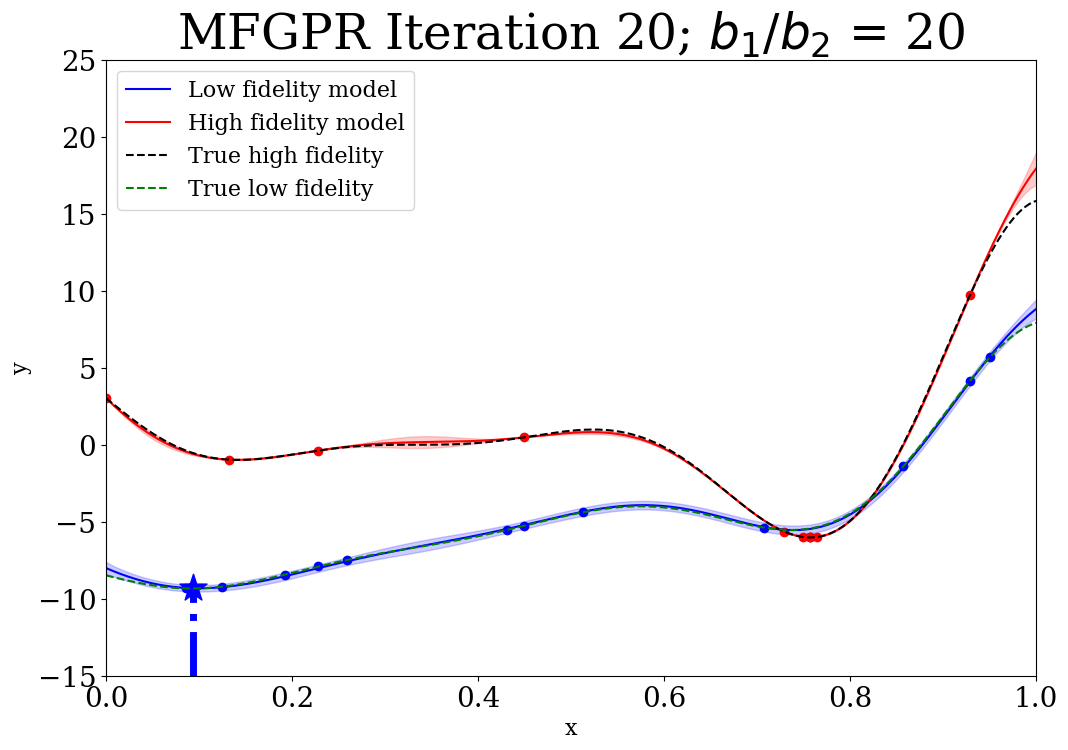

In [1007]:
from matplotlib import animation
fig = plt.figure(figsize=FIG_SIZE)
fig.clear()

# Animation Function
def animate(i):  
    """This function will be called by the animation function iteratively to plot"""
    fig.clear()
    colours = ['b', 'r']
    is_high_fidelity = Xlist[i][:, -1] == 1
    x_low=Xlist[i][~is_high_fidelity, 0]
    y_low=ylist[i][~is_high_fidelity]
    x_high=Xlist[i][is_high_fidelity, 0]
    y_high=ylist[i][is_high_fidelity]

    mean_low, var_low = GP_mean_l_list[i], GP_variance_l_list[i]
    mean_high, var_high = GP_mean_h_list[i], GP_variance_h_list[i]
    
    plt.plot(x_plot_high[:, 0], mean_low, color='b')
    plt.fill_between(x_plot_high[:, 0].flatten(),
                     mean_low.flatten() - 1.96*var_low.flatten(),
                     mean_low.flatten() + 1.96*var_low.flatten(), alpha=0.2, color='b')

    plt.plot(x_plot_high[:, 0], mean_high, color='r')
    plt.fill_between(x_plot_high[:, 0].flatten(),
                     mean_high.flatten() - 1.96*var_high.flatten(),
                     mean_high.flatten() + 1.96*var_high.flatten(), alpha=0.2, color='r')
    
    plt.plot(x_plot, forrester_fcn_high(x_plot), 'k--')
    plt.plot(x_plot, forrester_fcn_low(x_plot), 'g--')
    plt.scatter(x_low, y_low, color='b')
    plt.scatter(x_high, y_high, color='r')

    xnew = xnew_list[i]
    fidelity_idx = int(xnew[0, -1])
    ynew = forrester_fcn.f[fidelity_idx](xnew[0,0])
    plt.scatter(xnew[0, 0], 
                ynew, 
                color=colours[fidelity_idx], marker='*', s=420)
    
    plt.vlines(xnew[0,0], -15, ynew, linestyle='-.', linewidth=5, color=colours[fidelity_idx])
    
    plt.legend(['Low fidelity model', 'High fidelity model', 'True high fidelity', 'True low fidelity'])
    plt.xlim(0, 1)
    plt.ylim(-15,25)
    plt.xlabel('x')
    plt.ylabel('y');    
    print(i)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title(r'MFGPR Iteration {}; $b_1/b_2$ = 20'.format(i+1), fontsize=35)
    
    
ani = animation.FuncAnimation(fig, animate, frames=(len(xnew_list))) #animation function. frames will iterate i in animate
ani.save('MFGP_emu_toy20.gif', writer='pillow', fps=1) #save animation

In [729]:
# Plot 
n1list = []
n2list = []
reglist = []
blist = np.linspace(20, 0, 100, endpoint=False)[::-1]
for i in blist:
    np.random.seed(12346)
    # Create initial dataset
    x_low = np.random.rand(12)[:, None]
    x_high = x_low[:3, :]
    
    n_init = len(x_low)+len(x_high)
    
    y_low = forrester_fcn_low(x_low)
    y_high = forrester_fcn_high(x_high)

    # Create autoregressive hierarchial GP model
    
    x_array, y_array = convert_xy_lists_to_arrays([x_low, x_high], [y_low, y_high])
    
    kern_low = GPy.kern.RBF(1)
    kern_low.lengthscale.constrain_bounded(0.01, 0.5)
    
    kern_err = GPy.kern.RBF(1)
    kern_err.lengthscale.constrain_bounded(0.01, 0.5)
    
    multi_fidelity_kernel = LinearMultiFidelityKernel([kern_low, kern_err])
    gpy_model = GPyLinearMultiFidelityModel(x_array, y_array, multi_fidelity_kernel, n_fidelities)
    
    gpy_model.likelihood.Gaussian_noise.fix(0.1)
    gpy_model.likelihood.Gaussian_noise_1.fix(0)
    
    model = GPyMultiOutputWrapper(gpy_model, 2, 5, verbose_optimization=False)
    model.optimize()


    acquisition = CustomMultiFidelityAcquisition(model, parameter_space, i)


    initial_loop_state = create_loop_state(x_array, y_array)
    acquisition_optimizer = MultiSourceAcquisitionOptimizer(GradientAcquisitionOptimizer(parameter_space), parameter_space)
    candidate_point_calculator = SequentialPointCalculator(acquisition, acquisition_optimizer)
    model_updater = FixedIntervalUpdater(model)
    loop = OuterLoop(candidate_point_calculator, model_updater, initial_loop_state)

    x_search = np.stack([np.linspace(0, 1, 1000), np.ones(1000)], axis=1)

    model_min_mean = []
    model_min_loc = []
    def calculate_metrics(loop, loop_state):
        mean, var = loop.model_updaters[0].model.predict(x_search)
        model_min_mean.append(np.min(mean))
        model_min_loc.append(x_search[np.argmin(mean), 0])
    
    # subscribe to event
    loop.iteration_end_event.append(calculate_metrics)
    loop.run_loop(forrester_fcn, 20)
    n1 = sum(model.X[:, 1] == 0) # LF points
    n2 = sum(model.X[:, 1] == 1) # HF points
    n1list.append(n1)
    n2list.append(n2)
    reglist.append(model.X[model.X[:, 1] == 1][np.argmin(model.Y[model.X[:, 1] == 1]), 0])
    print(np.argmin(abs((blist - i))))
    

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


0


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


1


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


2


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


3


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


4


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


5


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


6


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


7


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


8


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


9


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


10


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


11


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


12


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


13


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


14


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


15


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


16


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


17


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


18


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


19


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


20


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


21


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


22


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


23


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


24


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


25


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


26


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


27


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


28


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


29


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


30


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


31


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


32


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


33


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


34


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


35


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


36


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


37


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


38


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


39


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


40


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


41


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


42


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


43


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


44


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


45


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


46


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


47


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


48


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


49


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


50


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


51


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


52


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


53


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


54


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


55


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


56


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


57


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


58


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


59


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


60


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


61


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


62


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


63


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


64


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


65


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


66


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


67


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


68


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


69


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


70


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


71


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


72


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


73


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


74


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


75


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


76


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


77


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


78


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


79


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


80


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


81


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


82


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


83


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


84


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


85


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


86


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


87


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


88


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


89


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


90


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


91


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


92


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


93


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


94


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


95


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


96


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


97


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


98
99


In [808]:
import emukit.test_functions.forrester

# The multi-fidelity Forrester function is already wrapped as an Emukit UserFunction object in 
# the test_functions package
forrester_fcn, _ = emukit.test_functions.forrester.multi_fidelity_forrester_function()
forrester_fcn_low = forrester_fcn.f[0]
forrester_fcn_high = forrester_fcn.f[1]

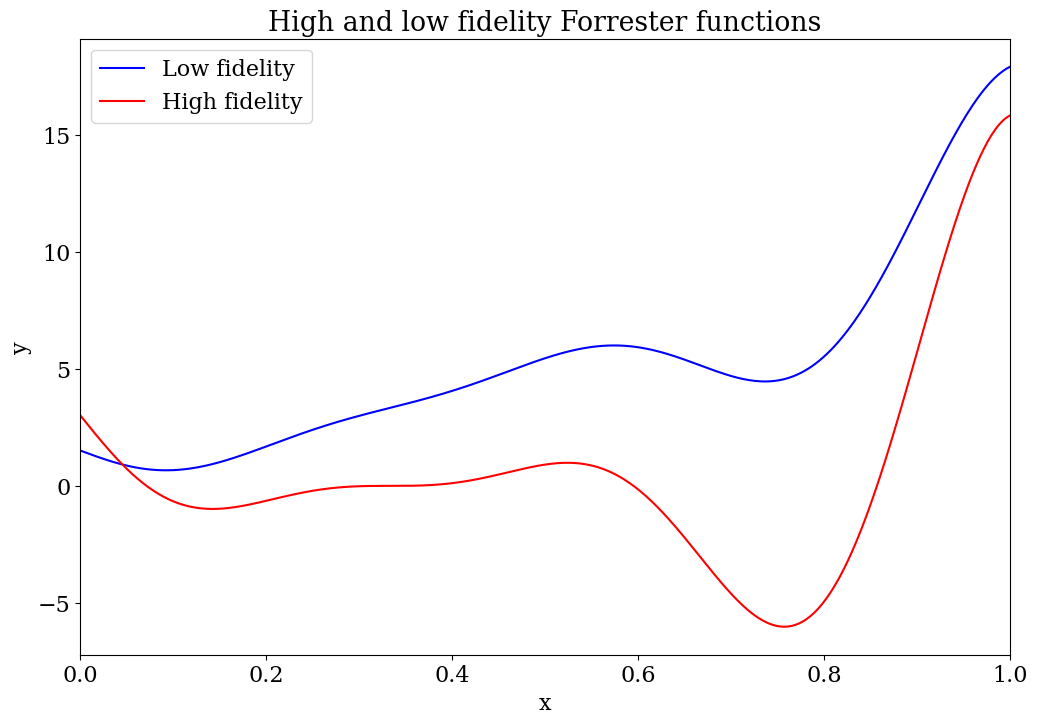

In [810]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
FIG_SIZE = (12, 8)
import numpy as np
np.random.seed(12345)
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array

n_plot_points = 100
x_plot = np.linspace(0, 1, 500)[:, None]
y_plot_low = forrester_fcn_low(x_plot)
y_plot_high = forrester_fcn_high(x_plot)

plt.figure(figsize=FIG_SIZE)
plt.plot(x_plot, y_plot_low, 'b')
plt.plot(x_plot, y_plot_high, 'r')
plt.legend(['Low fidelity', 'High fidelity'])
plt.xlim(0, 1)
plt.title('High and low fidelity Forrester functions')
plt.xlabel('x')
plt.ylabel('y');
plt.show()

In [812]:
# Plot 
n1lista = []
n2lista = []
reglista = []
blist = np.linspace(20, 0, 100, endpoint=False)[::-1]
for i in blist:
    np.random.seed(12346)
    n_fidelities = 2

    parameter_space = ParameterSpace([ContinuousParameter('x', 0, 1), InformationSourceParameter(n_fidelities)])

    # Create initial dataset
    x_low = np.random.rand(12)[:, None]
    x_high = x_low[:3, :]
    
    n_init = len(x_low)+len(x_high)
    
    y_low = forrester_fcn_low(x_low)
    y_high = forrester_fcn_high(x_high)

    # Create autoregressive hierarchial GP model
    
    x_array, y_array = convert_xy_lists_to_arrays([x_low, x_high], [y_low, y_high])
    
    kern_low = GPy.kern.RBF(1)
    kern_low.lengthscale.constrain_bounded(0.01, 0.5)
    
    kern_err = GPy.kern.RBF(1)
    kern_err.lengthscale.constrain_bounded(0.01, 0.5)
    
    multi_fidelity_kernel = LinearMultiFidelityKernel([kern_low, kern_err])
    gpy_model = GPyLinearMultiFidelityModel(x_array, y_array, multi_fidelity_kernel, n_fidelities)
    
    gpy_model.likelihood.Gaussian_noise.fix(0.1)
    gpy_model.likelihood.Gaussian_noise_1.fix(0)
    
    model = GPyMultiOutputWrapper(gpy_model, 2, 5, verbose_optimization=False)
    model.optimize()


    acquisition = CustomMultiFidelityAcquisition(model, parameter_space, i)


    initial_loop_state = create_loop_state(x_array, y_array)
    acquisition_optimizer = MultiSourceAcquisitionOptimizer(GradientAcquisitionOptimizer(parameter_space), parameter_space)
    candidate_point_calculator = SequentialPointCalculator(acquisition, acquisition_optimizer)
    model_updater = FixedIntervalUpdater(model)
    loop = OuterLoop(candidate_point_calculator, model_updater, initial_loop_state)

    x_search = np.stack([np.linspace(0, 1, 1000), np.ones(1000)], axis=1)

    model_min_mean = []
    model_min_loc = []
    def calculate_metrics(loop, loop_state):
        mean, var = loop.model_updaters[0].model.predict(x_search)
        model_min_mean.append(np.min(mean))
        model_min_loc.append(x_search[np.argmin(mean), 0])
    
    # subscribe to event
    loop.iteration_end_event.append(calculate_metrics)
    loop.run_loop(forrester_fcn, 20)
    n1 = sum(model.X[:, 1] == 0) # LF points
    n2 = sum(model.X[:, 1] == 1) # HF points
    n1lista.append(n1)
    n2lista.append(n2)
    reglista.append(model.X[model.X[:, 1] == 1][np.argmin(model.Y[model.X[:, 1] == 1]), 0])
    print(np.argmin(abs((blist - i))))

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


0


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


1


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


2


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


3


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


4


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


5


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


6


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


7


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


8


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


9


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


10


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


11


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


12


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


13


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


14


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


15


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


16


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


17


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


18


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


19


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


20


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


21


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


22


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


23


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


24


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


25


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


26


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


27


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


28


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


29


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


30


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


31


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


32


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


33


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


34


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


35


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


36


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


37


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


38


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


39


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


40


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


41


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


42


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


43


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


44


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


45


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


46


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


47


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


48


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


49


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


50


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


51


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


52


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


53


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


54


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


55


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


56


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


57


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


58


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


59


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


60


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


61


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


62


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


63


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


64


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


65


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


66


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


67


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


68


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


69


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


70


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


71


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


72


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


73


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


74


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


75


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


76


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


77


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


78


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


79


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


80


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


81


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


82


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


83


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


84


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


85


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


86


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


87


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


88


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


89


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


90


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


91


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


92


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


93


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


94


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


95


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


96


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


97


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


98
99


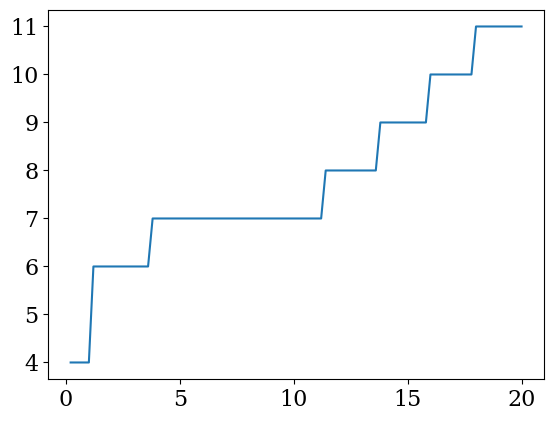

In [813]:
plt.plot(blist, n2list)

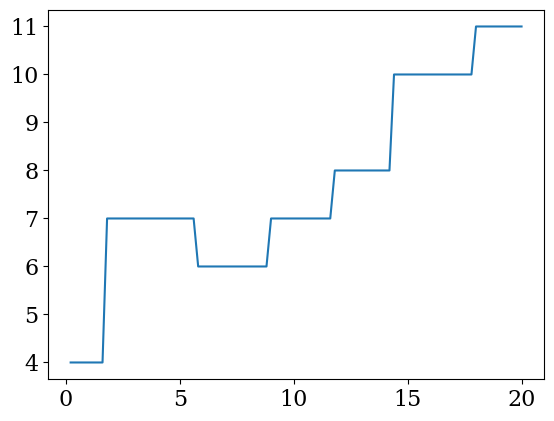

In [814]:
plt.plot(blist, n2lista)

Text(0, 0.5, '$n_high/n_low$')

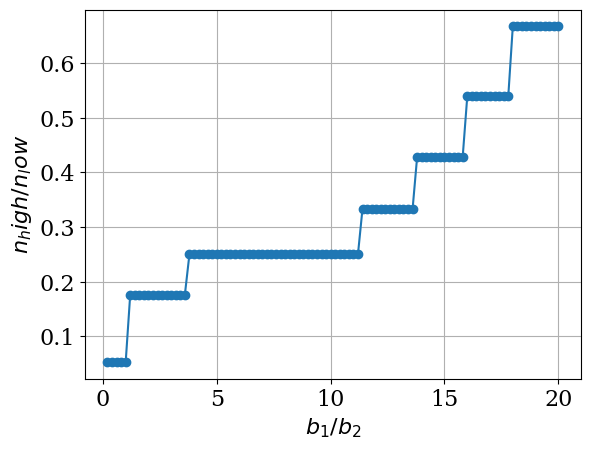

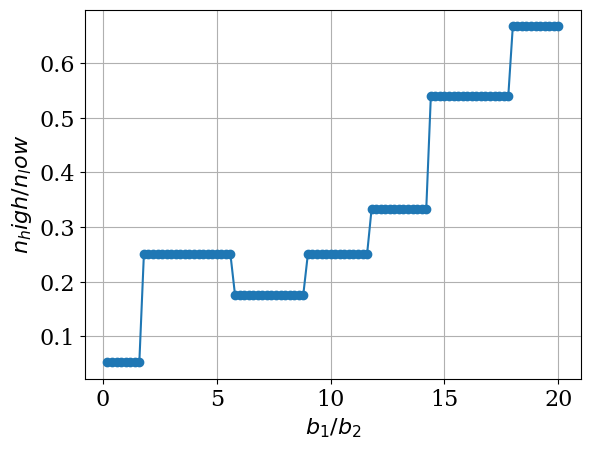

In [896]:
n1list = np.array(n1list) -12
n2list = np.array(n2list) -3
n1lista = np.array(n1lista) -12
n2lista = np.array(n2lista) -3

plt.figure()
plt.plot(blist, n2list/n1list, '-o')
plt.grid(True)
plt.xlabel(r'$b_1/b_2$')
plt.ylabel(r'$n_high/n_low$')

plt.figure()
plt.plot(blist, n2lista/n1lista, '-o')
plt.grid(True)
plt.xlabel(r'$b_1/b_2$')
plt.ylabel(r'$n_high/n_low$')

In [816]:
true_min = x_plot[np.argmin(y_plot_high)]

Text(0, 0.5, 'Regret, |$x$ - $x^*$|')

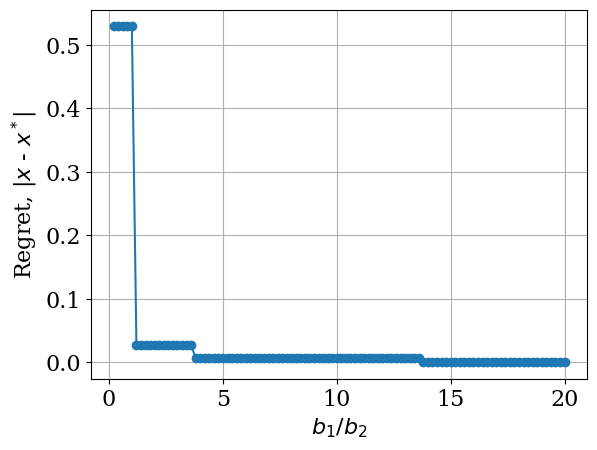

In [878]:
plt.plot(blist, abs(reglist - true_min), '-o')
plt.grid(True)
plt.xlabel(r'$b_1/b_2$')
plt.ylabel('Regret, |$x$ - $x^*$|')

In [818]:
blist[25]

5.199999999999999

Text(0, 0.5, 'Regret, |$x$ - $x^*$|')

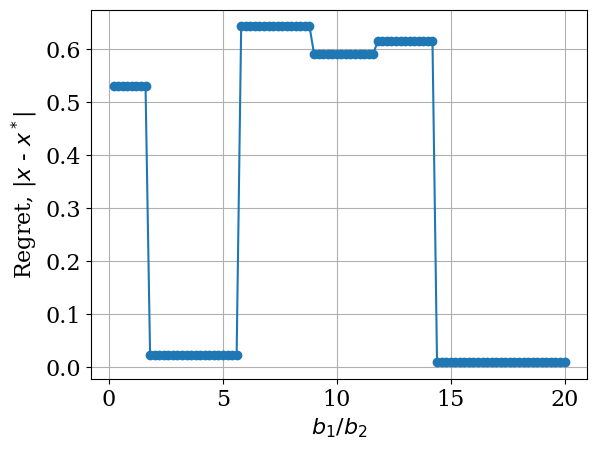

In [882]:
plt.plot(blist, abs(reglista - true_min), '-o')
plt.grid(True)
plt.xlabel(r'$b_1/b_2$')
plt.ylabel('Regret, |$x$ - $x^*$|')

In [820]:
# Define Multi-fidelity function and wrap in emukit

from emukit.core.loop.user_function import MultiSourceFunctionWrapper


def low_fidelity_toy(x):
    return np.sin(2 * np.pi * x) +  np.cos(6 * np.pi * x)
    

def high_fidelity_toy(x):
    return np.sin(2 * np.pi * x) + 0.5 * np.cos(4 * np.pi * x)

# Wrap the function using MultiSourceFunctionWrapper
forrester_fcn = MultiSourceFunctionWrapper([low_fidelity_toy,
                                               high_fidelity_toy])

forrester_fcn_low = forrester_fcn.f[0]
forrester_fcn_high = forrester_fcn.f[1]

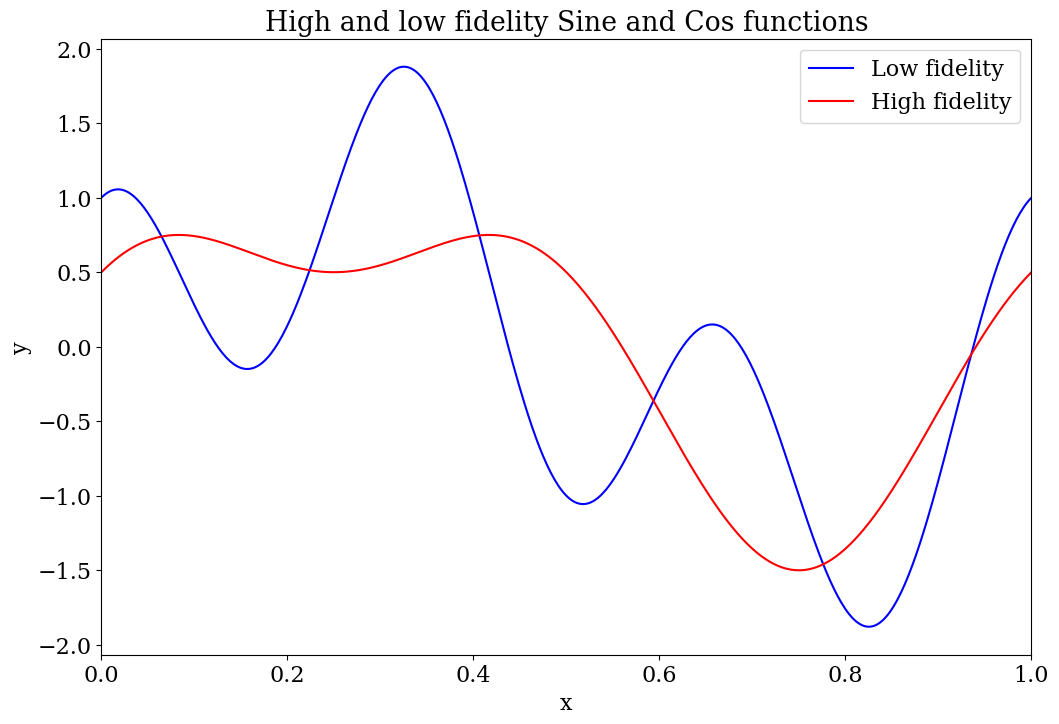

In [850]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
FIG_SIZE = (12, 8)
import numpy as np
np.random.seed(12345)
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array

n_plot_points = 100
x_plot = np.linspace(0, 1, 500)[:, None]
y_plot_low = forrester_fcn_low(x_plot)
y_plot_high = forrester_fcn_high(x_plot)
plt.rc('font', family='serif')
plt.figure(figsize=FIG_SIZE)
plt.plot(x_plot, y_plot_low, 'b')
plt.plot(x_plot, y_plot_high, 'r')
plt.legend(['Low fidelity', 'High fidelity'])
plt.xlim(0, 1)
plt.title('High and low fidelity Sine and Cos functions')
plt.xlabel('x')
plt.ylabel('y');
plt.show()

In [822]:
# Plot 
n1listb = []
n2listb = []
reglistb = []
blist = np.linspace(20, 0, 100, endpoint=False)[::-1]
for i in blist:
    np.random.seed(12346)
    n_fidelities = 2

    parameter_space = ParameterSpace([ContinuousParameter('x', 0, 1), InformationSourceParameter(n_fidelities)])

    # Create initial dataset
    x_low = np.random.rand(12)[:, None]
    x_high = x_low[:3, :]
    
    n_init = len(x_low)+len(x_high)
    
    y_low = forrester_fcn_low(x_low)
    y_high = forrester_fcn_high(x_high)

    # Create autoregressive hierarchial GP model
    
    x_array, y_array = convert_xy_lists_to_arrays([x_low, x_high], [y_low, y_high])
    
    kern_low = GPy.kern.RBF(1)
    kern_low.lengthscale.constrain_bounded(0.01, 0.5)
    
    kern_err = GPy.kern.RBF(1)
    kern_err.lengthscale.constrain_bounded(0.01, 0.5)
    
    multi_fidelity_kernel = LinearMultiFidelityKernel([kern_low, kern_err])
    gpy_model = GPyLinearMultiFidelityModel(x_array, y_array, multi_fidelity_kernel, n_fidelities)
    
    gpy_model.likelihood.Gaussian_noise.fix(0.1)
    gpy_model.likelihood.Gaussian_noise_1.fix(0)
    
    model = GPyMultiOutputWrapper(gpy_model, 2, 5, verbose_optimization=False)
    model.optimize()


    acquisition = CustomMultiFidelityAcquisition(model, parameter_space, i)


    initial_loop_state = create_loop_state(x_array, y_array)
    acquisition_optimizer = MultiSourceAcquisitionOptimizer(GradientAcquisitionOptimizer(parameter_space), parameter_space)
    candidate_point_calculator = SequentialPointCalculator(acquisition, acquisition_optimizer)
    model_updater = FixedIntervalUpdater(model)
    loop = OuterLoop(candidate_point_calculator, model_updater, initial_loop_state)

    x_search = np.stack([np.linspace(0, 1, 1000), np.ones(1000)], axis=1)

    model_min_mean = []
    model_min_loc = []
    def calculate_metrics(loop, loop_state):
        mean, var = loop.model_updaters[0].model.predict(x_search)
        model_min_mean.append(np.min(mean))
        model_min_loc.append(x_search[np.argmin(mean), 0])
    
    # subscribe to event
    loop.iteration_end_event.append(calculate_metrics)
    loop.run_loop(forrester_fcn, 20)
    n1 = sum(model.X[:, 1] == 0) # LF points
    n2 = sum(model.X[:, 1] == 1) # HF points
    n1listb.append(n1)
    n2listb.append(n2)
    reglistb.append(model.X[model.X[:, 1] == 1][np.argmin(model.Y[model.X[:, 1] == 1]), 0])
    print(np.argmin(abs((blist - i))))

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


0


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


1


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


2


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


3


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


4


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


5


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


6


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


7


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


8


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


9


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


10


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


11


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


12


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


13


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


14


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


15


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


16


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


17


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


18


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


19


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


20


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


21


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


22


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


23


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


24


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


25


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


26


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


27


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


28


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


29


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


30


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


31


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


32


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


33


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


34


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


35


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


36


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


37


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


38


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


39


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


40


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


41


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


42


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


43


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


44


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


45


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


46


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


47


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


48


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


49


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


50


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


51


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


52


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


53


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


54


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


55


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


56


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


57


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


58


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


59


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


60


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


61


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


62


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


63


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


64


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


65


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


66


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


67


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


68


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


69


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


70


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


71


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


72


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


73


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


74


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


75


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


76


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


77


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


78


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


79


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


80


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


81


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


82


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


83


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


84


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


85


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


86


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


87


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


88


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


89


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


90


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


91


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


92


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


93


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


94


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


95


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


96


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


97


reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


98
99


Text(0, 0.5, '$n_high/n_low$')

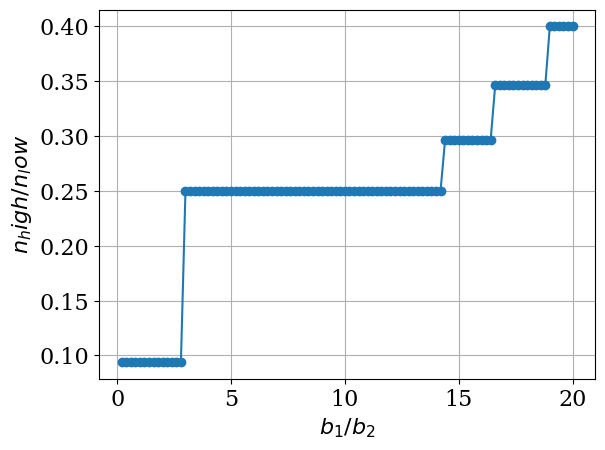

In [886]:
n1listb = np.array(n1listb)
n2listb = np.array(n2listb)
plt.figure()
plt.plot(blist, n2listb/n1listb, '-o')
plt.grid(True)
plt.xlabel(r'$b_1/b_2$')
plt.ylabel(r'$n_high/n_low$')

Text(0, 0.5, 'Regret, |$x$ - $x^*$|')

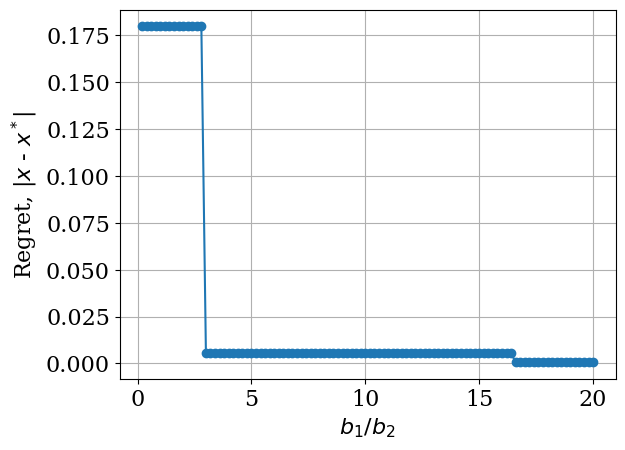

In [890]:
true_minb = x_plot[np.argmin(y_plot_high)]

plt.plot(blist, abs(reglistb - true_minb), '-o')
plt.grid(True)
plt.xlabel(r'$b_1/b_2$')
plt.ylabel('Regret, |$x$ - $x^*$|')

In [852]:
true_minb = x_plot[np.argmin(y_plot_high)]

In [854]:
true_minb

array([0.749499])

In [856]:
np.min(y_plot_high)

-1.4999851362344663

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])